# Cell 0 — Imports + financial helper functions (the “accounting layer”)

This cell sets up the Python environment and defines the *financial math* that later converts an hourly storage dispatch (which produces euros per hour) into a **net present value (NPV)** over many years.

## What happens here
- **Imports**: `numpy` (numerical arrays), `pandas` (tables/time series), `matplotlib` (plots), and `gurobipy` (Gurobi solver interface).
- **Hard stop if Gurobi is missing**: the optimisation model is solved with Gurobi; without it the notebook cannot run.
- **Defines helper functions** used by the optimisation objective:
  - `pw_factor(r, H)`: the present-worth factor \(P/A\) that converts a constant annual cashflow into its present value:
    \[
    P/A(r,H) = \sum_{k=1}^{H}\frac{1}{(1+r)^k} = \frac{1-(1+r)^{-H}}{r}.
    \]
  - `pw_factor_shifted(r, H, start_delay)`: same factor, but cashflows start after a delay (e.g., commissioning delay).
  - `pw_factor_growth_shifted(r, g, H, start_delay)`: present-worth factor when the annual cashflow grows by a constant drift \(g\) (used to model long-run price drift).
  - `as_2d(a)`: forces vectors into a 2D array shape \((S,T)\) so “scenario × time” operations are consistent.
  - `build_capex_multiplier_series(...)`: builds a year-by-year multiplier vector that tells the model **when CAPEX is paid** (multi‑year construction), **when it repeats** (replacements), and **how it changes by year** (either a constant escalation rate or an explicit year-index vector).

## Why this cell exists (conceptually)
Your optimisation has two time scales:
1. **Operational**: hourly charging/discharging decisions over one representative year (\(T=8760\)).
2. **Financial**: investment, O&M, subsidies and salvage over a project horizon of \(H\) years.

The helper functions are what let the model say:
- “This dispatch makes X €/year in *expected* operating profit”  
  **and then**
- “Over H years, discounted at rate r, that is worth PV = … € today.”

This separation is important: it keeps the optimisation linear and interpretable, while still producing NPV (the metric you compare technologies on).


In [8]:
# =========================
# 0) Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

try:
    import gurobipy as gp
    from gurobipy import GRB
except Exception as e:
    raise RuntimeError(
        "This notebook cell requires gurobipy + a working Gurobi license.\n"
        f"Import error: {repr(e)}"
    )

# -------------------------
# Helpers
# -------------------------
def pw_factor(r: float, H: int) -> float:
    """Present-worth factor P/A(r,H)."""
    if H <= 0:
        return 0.0
    if abs(r) < 1e-12:
        return float(H)
    return (1.0 - (1.0 + r) ** (-H)) / r

def as_2d(a):
    a = np.asarray(a)
    if a.ndim == 1:
        return a[None, :]
    return a

# -------------------------
# Cashflow helpers (construction delays, drift, CAPEX schedules)
# -------------------------
def pw_factor_shifted(r: float, H: int, start_delay_years: int = 0) -> float:
    """Present-worth factor for an annual cashflow received at end of each year,
    starting after `start_delay_years` full years (i.e., first cashflow at end of year start_delay_years+1)."""
    start_delay_years = int(max(0, start_delay_years))
    if H <= start_delay_years:
        return 0.0
    return (1.0 + r) ** (-start_delay_years) * pw_factor(r, H - start_delay_years)

def pw_factor_growth_shifted(r: float, g: float, H: int, start_delay_years: int = 0) -> float:
    """Present-worth factor for an annual cashflow received at end of each year that grows by (1+g) per year.
    Growth applies to the *cashflow level* in year k relative to year 0 (k=0..H-1).
    Cashflows start after `start_delay_years` full years (first at end of year start_delay_years+1)."""
    start_delay_years = int(max(0, start_delay_years))
    if H <= start_delay_years:
        return 0.0

    # PV = sum_{k=start_delay..H-1} (1+g)^k / (1+r)^{k+1} = (1/(1+r)) * sum_{k=start_delay..H-1} q^k
    if abs(r) < 1e-12:
        # r ~ 0: PV = sum_{k=start_delay..H-1} (1+g)^k
        if abs(g) < 1e-12:
            return float(H - start_delay_years)
        return ((1.0 + g) ** start_delay_years) * ((1.0 + g) ** (H - start_delay_years) - 1.0) / g

    q = (1.0 + g) / (1.0 + r)
    if abs(q - 1.0) < 1e-12:
        # q ~ 1 => each term is ~1/(1+r); start_delay adds a q^start_delay factor ~1
        return (H - start_delay_years) / (1.0 + r)

    geom = (q ** start_delay_years) * (1.0 - q ** (H - start_delay_years)) / (1.0 - q)
    return geom / (1.0 + r)

def build_capex_multiplier_series(
    H: int,
    lifetime_years: int | None,
    construction_years: int = 0,
    capex_payment_profile: list[float] | None = None,
    replacement_required: bool = True,
    capex_escalation_annual: float = 0.0,
    capex_index_by_year: np.ndarray | None = None,
) -> np.ndarray:
    """Return an array mult[y] such that:

        PV(CAPEX) = CAPEX_base * sum_y mult[y] / (1+r)^y.

    Where:
    - CAPEX_base is the (discounted/grant-adjusted) CAPEX associated with the chosen design (E,Pch,Pdis),
      stated in *base-year* euros.
    - construction_years spreads each build over multiple years (payments at the *start* of each year y).
    - lifetime_years triggers reinvestment every `lifetime_years` (if replacement_required=True).
    - capex_escalation_annual scales replacement CAPEX at install year y0 by (1+capex_escalation_annual)^y0.

    If `capex_index_by_year` is provided, it overrides the escalation logic and applies a year-specific
    multiplier to each payment year y:
        mult[y] += frac * capex_index_by_year[y]
    This supports arbitrary CAPEX paths (e.g., learning curves, discrete policy changes).
    The array must have length >= H and be relative to the base year (base year multiplier = 1.0).
    """
    if construction_years <= 0:
        capex_payment_profile = [1.0]
    else:
        if capex_payment_profile is None:
            capex_payment_profile = [1.0 / construction_years] * construction_years
        else:
            # Normalize if slightly off due to rounding
            s = float(sum(capex_payment_profile))
            if s <= 0:
                raise ValueError("capex_payment_profile must sum to a positive value.")
            capex_payment_profile = [float(x) / s for x in capex_payment_profile]

    if (capex_index_by_year is not None) and (len(capex_index_by_year) < H):
        raise ValueError("capex_index_by_year must have length at least H.")

    if (lifetime_years is None) or (not replacement_required) or (lifetime_years <= 0):
        install_years = [0]
    else:
        L = int(lifetime_years)
        install_years = list(range(0, H, L))

    mult = np.zeros(H, dtype=float)
    for y0 in install_years:
        if capex_index_by_year is None:
            install_multiplier = (1.0 + capex_escalation_annual) ** y0
            for j, frac in enumerate(capex_payment_profile):
                y = y0 + j
                if y >= H:
                    break
                mult[y] += float(frac) * install_multiplier
        else:
            # Apply the index at the *payment year* (not the install year),
            # which matches how contracts/invoices are typically indexed.
            for j, frac in enumerate(capex_payment_profile):
                y = y0 + j
                if y >= H:
                    break
                mult[y] += float(frac) * float(capex_index_by_year[y])
    return mult


# Cell 1 — Build a 8760-hour “typical year” production profile from a (month, hour) lookup table

This cell defines a utility function that converts a compact seasonal profile (12 months × 24 hours = 288 rows) into a full **hour-by-hour** time series of length 8760 (one non‑leap year).

## What the function does
`build_hourly_profile_from_month_hour_csv(...)`:
1. **Reads a CSV** containing average power values indexed by `(month, hour)`.
2. **Validates completeness**: it checks that all 288 combinations exist. If any are missing, it stops with an error (this prevents silent gaps later).
3. **Creates a non-leap-year hourly timestamp index** (e.g., 2021-01-01 .. 2022-01-01, 8760 hours).
4. **Maps each timestamp to its (month, hour)** and merges with the lookup table.
5. **Checks for NaNs** after the merge (meaning the mapping failed).
6. **Returns a NumPy array** of 8760 hourly values, clipped at zero to avoid negative power.

## Why this matters for the optimisation model
Later, the storage model needs a time series `surplus[t]` that represents *how much power is available for charging* at each hour. For example:
- If you use a wind farm production profile, `surplus[t]` is “available wind power (or curtailment)”.
- If you use a price-proxy, `surplus[t]` is “available charging power during low-price hours”.

This function provides the first option: a realistic *seasonal-and-diurnal* profile that can be used as `surplus`.


In [9]:
def build_hourly_profile_from_month_hour_csv(
    csv_path: str = "gemini_avg_power_month_hour_2017_2019_long.csv",
    month_col: str = "month",
    hour_col: str = "hour",
    value_col: str = "avg_power",
    base_year: int = 2021,     # non-leap year => 8760 hours
    tz: str = "UTC",
) -> np.ndarray:
    """
    Converts a (month, hour)->value table (288 rows) into a chronological 8760-hour profile.

    Returns
    -------
    profile : np.ndarray shape (8760,)
        Hourly values for a typical year.
    """
    df = pd.read_csv(csv_path)

    required = {month_col, hour_col, value_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}. Found: {list(df.columns)}")

    df = df[[month_col, hour_col, value_col]].copy()
    df[month_col] = df[month_col].astype(int)
    df[hour_col] = df[hour_col].astype(int)
    df[value_col] = df[value_col].astype(float)

    # Ensure full 12x24 coverage
    all_pairs = pd.MultiIndex.from_product(
        [range(1, 13), range(0, 24)],
        names=[month_col, hour_col]
    )
    df = df.set_index([month_col, hour_col]).reindex(all_pairs)

    if df[value_col].isna().any():
        missing_pairs = df[df[value_col].isna()].index.tolist()[:10]
        raise ValueError(
            f"Incomplete month-hour table in {csv_path}. Missing examples: {missing_pairs}. "
            "Need all 12*24=288 combinations."
        )

    # Create hourly timestamps for a non-leap year
    idx = pd.date_range(
        start=f"{base_year}-01-01",
        end=f"{base_year+1}-01-01",
        freq="h",
        inclusive="left",
        tz=tz
    )
    if len(idx) != 8760:
        raise RuntimeError(f"Expected 8760 hours, got {len(idx)} for base_year={base_year}.")

    tmp = pd.DataFrame({"ts": idx})
    tmp["month"] = tmp["ts"].dt.month
    tmp["hour"] = tmp["ts"].dt.hour

    lut = df.reset_index().rename(columns={value_col: "val"})
    tmp = tmp.merge(lut, on=["month", "hour"], how="left")

    if tmp["val"].isna().any():
        raise RuntimeError("Mapping month-hour -> hourly series failed (NaNs after merge).")

    profile = tmp["val"].to_numpy(dtype=float)
    profile = np.clip(profile, 0.0, None)
    return profile

# Cell 2 — Load price data, create price scenarios, and define “surplus” charging availability

This cell turns raw historical day-ahead prices into the model inputs needed for stochastic optimisation:
- `prices[s,t]`: electricity price for scenario \(s\) at hour \(t\)
- `scenario_prob[s]`: probability of each scenario
- `surplus[s,t]`: the *maximum charging power* available at each hour (per scenario)

## Step-by-step overview

### A) Load and clean the price time series
The code reads the combined day-ahead dataset and enforces a clean hourly grid:
- parse timestamps with timezones,
- sort and deduplicate,
- reindex to hourly frequency,
- fill missing hours (interpolation),
- ensure each year has exactly 8760 hours (no leap-day).

This matters because the optimisation model assumes a fixed time index and would otherwise misalign constraints (e.g., SOC dynamics).

### B) Build **pricing scenarios**
You can run with different scenario modes (controlled by `SCENARIO_MODE`):
- **Historical-years mode**: each full year becomes one scenario (empirical distribution).
- **Synthetic 3-case mode**: creates three stylised scenarios (BEST / NORMAL / BAD).  
  NORMAL is constructed as a seasonal mean plus block-bootstrap residuals to preserve autocorrelation (so price spikes occur in realistic clusters rather than independently).

This is the key stochastic element: you are not optimising for a single price path, but for an expected value across multiple plausible price worlds.

### C) Define `year_scale`
If you ever run a shorter time horizon (e.g., a subset of hours for testing), `year_scale = 8760/(T·dt)` rescales annual profits so the NPV remains comparable.

### D) Define **surplus charging availability**
The model needs a constraint like:
\[
\text{charge}_{s,t} \le \text{surplus}_{s,t}.
\]
This cell supports two interpretations:
- **Gemini / profile-based surplus**: surplus comes from a production profile (e.g., wind).
- **Price-proxy surplus**: surplus is “available during the lowest-price quantile hours” to mimic congestion/curtailment periods.

The critical modelling point is that `surplus` is not “free energy”; it is a *power limit* on how much charging you are allowed to do. Economic value still comes from price arbitrage and subsidies.

## Outputs created by this cell
After this cell runs, the optimisation has all time-series inputs it needs:
- `prices` (shape \(S,T\))
- `scenario_prob` (length \(S\))
- `surplus` (shape \(S,T\))
- `dt`, `T`, and the scaling factors used in the NPV objective.


In [10]:
# =========================
# 1) Price scenarios + surplus
#
# Goal:
# - Keep the optimization model at "one-year resolution" (T=8760) but allow long horizons (H_years up to 100)
# - Provide: (i) scenario year-profiles (best/normal/bad) and (ii) a drift parameter for long-run price level change
# - Provide optional explicit multi-year price paths for reporting/plotting (not used directly in the MILP)
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

dt = 1.0
hours_per_year = 8760

# -------------------------
# Paths (work both in notebook folder and in /mnt/data)
# -------------------------
def _resolve_path(p: str) -> str:
    pth = Path(p)
    if pth.exists():
        return str(pth)
    alt = Path("/mnt/data") / p
    if alt.exists():
        return str(alt)
    return str(pth)  # let pandas raise a clear error

price_path = _resolve_path("day_ahead_prices_2020_2025_combined.csv")
ts_col = "timestamp"
price_col = "price"

# Gemini profile (month, hour) -> 8760 hourly profile
gemini_power_path = _resolve_path(r"C:\Users\User\OneDrive\Univerity of Twente\IEM\Module 6\CM&E\Project\CM-E-Project\gemini_avg_power_month_hour_2017_2019_long.csv")

# -------------------------
# Test mode (optional)
# -------------------------
TEST_MODE = False          # True => use a short window
TEST_START_UTC = "2022-01-03 00:00:00"  # inclusive, UTC
TEST_DAYS = 7              # 7 days = 168 hours
TEST_TILE_TO_YEAR = False  # True => repeat the short window to 8760 hours

# -------------------------
# Scenario mode
# -------------------------
# "historical_years"   => each full calendar year in the dataset becomes a scenario
# "synthetic_3cases"   => build best/normal/bad year-profiles + estimate drift for long horizons
SCENARIO_MODE = "synthetic_3cases"

# Manual override if you want (example: -0.03 for -3%/yr)
PRICE_DRIFT_ANNUAL_OVERRIDE = None

# Volatility scaling inside each scenario profile (keeps seasonality, changes sd)
BEST_VOL_MULT = 0.85
NORMAL_VOL_MULT = 1.00
BAD_VOL_MULT = 1.35

# Optional level shifts (€/MWh) applied after volatility scaling
BEST_LEVEL_SHIFT = 0.0
NORMAL_LEVEL_SHIFT = 0.0
BAD_LEVEL_SHIFT = 0.0

# Scenario probabilities (must sum to 1)
SCENARIO_PROB = {"BEST": 1/3, "NORMAL": 1/3, "BAD": 1/3}

# -------------------------
# Load and clean prices (hourly grid, interpolate gaps, drop Feb-29)
# -------------------------
dfp = pd.read_csv(r"C:\Users\User\OneDrive\Univerity of Twente\IEM\Module 6\CM&E\Project\CM-E-Project\day_ahead_prices_2020_2025_combined.csv")
dfp[ts_col] = pd.to_datetime(dfp[ts_col], utc=True, errors="coerce")
dfp = dfp.dropna(subset=[ts_col, price_col]).sort_values(ts_col).set_index(ts_col)

# If testing, cut down early (faster)
if TEST_MODE:
    start_ts = pd.Timestamp(TEST_START_UTC, tz="UTC")
    end_ts = start_ts + pd.Timedelta(days=TEST_DAYS)
    dfp = dfp[(dfp.index >= start_ts) & (dfp.index < end_ts)]

price_series = (
    dfp[price_col].astype(float)
    .resample("h").mean()
    .interpolate("time")
)

# Drop Feb 29 so any "calendar year" is exactly 8760 hours
is_feb29 = (price_series.index.month == 2) & (price_series.index.day == 29)
price_series = price_series[~is_feb29]

# -------------------------
# Build scenario year-profiles
# -------------------------
def _extract_full_year_arrays(ps: pd.Series) -> dict[int, np.ndarray]:
    years = sorted(ps.index.year.unique())
    out = {}
    for y in years:
        ys = ps[ps.index.year == y]
        if len(ys) == hours_per_year:
            out[int(y)] = ys.to_numpy(dtype=float)
    return out

def _robust_drift_estimate(year_means: pd.Series) -> float:
    '''
    Estimate annual drift as a geometric growth rate from annual average prices.
    Uses a robust outlier filter (MAD) so a single spike-year (e.g., 2022) doesn't dominate.
    Returns g such that expected level scales by (1+g)^year.
    '''
    if len(year_means) < 2:
        return 0.0

    med = float(year_means.median())
    mad = float(np.median(np.abs(year_means.values - med)))
    if mad <= 1e-12:
        keep = year_means
    else:
        sigma = 1.4826 * mad
        keep = year_means[np.abs(year_means - med) <= 3.0 * sigma]
        if len(keep) < 2:
            keep = year_means

    x = (keep.index.to_numpy(dtype=float) - float(keep.index.min()))
    y = np.log(np.clip(keep.to_numpy(dtype=float), 1e-6, None))
    slope = float(np.polyfit(x, y, 1)[0])
    return float(np.exp(slope) - 1.0)

def _vol_level_transform(p: np.ndarray, vol_mult: float, level_shift: float) -> np.ndarray:
    mu = float(np.mean(p))
    return (mu + vol_mult * (p - mu) + level_shift).astype(float)

full_years = _extract_full_year_arrays(price_series)

if TEST_MODE and not TEST_TILE_TO_YEAR:
    # One scenario = the week (T=168)
    prices = price_series.to_numpy(dtype=float)[None, :]
    kept_years = [f"TEST_WEEK_FROM_{TEST_START_UTC}"]
    scenario_names = kept_years
    price_drift_annual = 0.0
else:
    if TEST_MODE and TEST_TILE_TO_YEAR:
        # Repeat test window to 8760 (index no longer needed for optimization)
        reps = hours_per_year // len(price_series)
        rem = hours_per_year - reps * len(price_series)
        tiled = np.concatenate([
            np.tile(price_series.to_numpy(float), reps),
            price_series.to_numpy(float)[:rem],
        ])
        prices = tiled[None, :]
        kept_years = [f"TEST_TILED_FROM_{TEST_START_UTC}"]
        scenario_names = kept_years
        price_drift_annual = 0.0

    else:
        if len(full_years) == 0:
            raise ValueError("No full 8760-hour years found in the price dataset after cleaning.")

        year_means = pd.Series({y: float(np.mean(arr)) for y, arr in full_years.items()}).sort_index()

        # Identify best and bad years from available full years
        bad_year = 2022 if 2022 in full_years else int(year_means.idxmax())
        best_year = int(year_means.idxmin())

        if SCENARIO_MODE == "historical_years":
            kept_years = sorted(full_years.keys())
            prices = np.vstack([full_years[y] for y in kept_years])
            scenario_names = [str(y) for y in kept_years]

        elif SCENARIO_MODE == "synthetic_3cases":
            # Build NORMAL from a mean seasonal profile (hour-of-year) + a block-bootstrap residual.
            years_for_normal = [y for y in full_years.keys() if y != bad_year] or list(full_years.keys())
            mat = np.vstack([full_years[y] for y in years_for_normal])  # (Ny,8760)
            seasonal_mean = mat.mean(axis=0)
            resid = mat - seasonal_mean  # (Ny,8760)

            rng = np.random.default_rng(42)
            block = 24  # daily blocks
            n_blocks = hours_per_year // block  # 365
            resid_blocks = resid.reshape(resid.shape[0], n_blocks, block)
            pick_y = rng.integers(0, resid.shape[0], size=n_blocks)
            pick_b = rng.integers(0, n_blocks, size=n_blocks)
            boot = resid_blocks[pick_y, pick_b].reshape(-1)

            normal_raw = seasonal_mean + boot
            best_raw = full_years[best_year]
            bad_raw = full_years[bad_year]

            best = _vol_level_transform(best_raw, BEST_VOL_MULT, BEST_LEVEL_SHIFT)
            normal = _vol_level_transform(normal_raw, NORMAL_VOL_MULT, NORMAL_LEVEL_SHIFT)
            bad = _vol_level_transform(bad_raw, BAD_VOL_MULT, BAD_LEVEL_SHIFT)

            prices = np.vstack([best, normal, bad])
            kept_years = [f"BEST_{best_year}", "NORMAL_SYNTH", f"BAD_{bad_year}"]
            scenario_names = kept_years
        else:
            raise ValueError(f"Unknown SCENARIO_MODE={SCENARIO_MODE}")

        # Drift estimate (unless overridden)
        drift_est = _robust_drift_estimate(year_means)
        price_drift_annual = float(drift_est if PRICE_DRIFT_ANNUAL_OVERRIDE is None else PRICE_DRIFT_ANNUAL_OVERRIDE)

# Scenario probabilities vector aligned with 'scenario_names'
if (not TEST_MODE) and (SCENARIO_MODE == "synthetic_3cases"):
    scenario_prob = np.array([SCENARIO_PROB["BEST"], SCENARIO_PROB["NORMAL"], SCENARIO_PROB["BAD"]], dtype=float)
    scenario_prob = scenario_prob / scenario_prob.sum()
else:
    S_tmp = int(np.asarray(prices).shape[0])
    scenario_prob = np.ones(S_tmp, dtype=float) / S_tmp

prices = np.asarray(prices, dtype=float)
S, T = prices.shape
year_scale = float(hours_per_year / (T * dt))  # =1.0 for T=8760; >1.0 for test windows

print(f"Scenario mode: {SCENARIO_MODE} | scenarios={scenario_names}")
print(f"prices shape: (S,T)=({S},{T}), year_scale={year_scale:.6g}")
print(f"price stats: min={prices.min():.2f}, mean={prices.mean():.2f}, max={prices.max():.2f}")
print(f"Estimated price drift (annual): {price_drift_annual:+.4%}  (override via PRICE_DRIFT_ANNUAL_OVERRIDE)")

# -------------------------
# Surplus (choose proxy from low prices OR Gemini profile)
# -------------------------
def make_surplus_proxy_from_prices(prices_ST: np.ndarray, surplus_max_mw: float = 50.0, low_quantile: float = 0.20) -> np.ndarray:
    thresh = np.quantile(prices_ST, low_quantile, axis=1, keepdims=True)
    return np.where(prices_ST <= thresh, surplus_max_mw, 0.0).astype(float)

# Build Gemini 8760-hour profile (avg power by month-hour)
gemini_profile = build_hourly_profile_from_month_hour_csv(
    gemini_power_path,
    month_col="month",
    hour_col="hour",
    value_col="avg_power",
    base_year=2021,
    tz="UTC",
)
gemini_profile = np.asarray(gemini_profile, dtype=float).ravel()

if len(gemini_profile) != hours_per_year:
    raise ValueError(f"Gemini profile length {len(gemini_profile)} must be {hours_per_year} after build.")

if T == hours_per_year:
    gemini_aligned = gemini_profile
else:
    gemini_aligned = gemini_profile[:T]

curtailment_fraction = 1.0  # set e.g. 0.3 if only 30% is realistically available
surplus_gemini_1y = np.clip(curtailment_fraction * gemini_aligned, 0.0, None)

# Per-scenario surplus (optionally vary year-to-year)
rng = np.random.default_rng(42)
year_sigma = 0.10  # 10% multiplicative variation across scenarios
scale_factors = rng.normal(1.0, year_sigma, size=(S, 1))

surplus_gemini = np.clip(np.tile(surplus_gemini_1y[None, :], (S, 1)) * scale_factors, 0.0, None)
surplus_proxy = make_surplus_proxy_from_prices(prices, surplus_max_mw=50.0, low_quantile=0.20)

SURPLUS_MODE = "gemini"  # "gemini" or "proxy"
surplus = surplus_gemini if SURPLUS_MODE.lower() == "gemini" else surplus_proxy

print(f"Surplus mode: {SURPLUS_MODE} | surplus shape: {surplus.shape}")
print(f"surplus stats: min={surplus.min():.2f}, mean={surplus.mean():.2f}, max={surplus.max():.2f}")

# -------------------------
# Optional helper: explicit multi-year hourly price paths (for reporting/plots).
# Not used directly by the MILP (keeps the optimization size manageable for H_years up to 100).
# -------------------------
def generate_multi_year_price_cube(
    base_prices_ST: np.ndarray,
    H_years: int,
    price_drift_annual: float = 0.0,
    vol_growth_annual: float = 0.0,
) -> np.ndarray:
    '''
    Returns price_cube[S,H,T]. Year y applies:
      level_y = (1+price_drift_annual)^y
      vol_y   = (1+vol_growth_annual)^y
      p_y,t = level_y * (mu + vol_y*(p0_t - mu))
    where mu is the within-year mean of p0 in each scenario.
    '''
    base_prices_ST = np.asarray(base_prices_ST, dtype=float)
    S0, T0 = base_prices_ST.shape
    H_years = int(H_years)
    mu = base_prices_ST.mean(axis=1, keepdims=True)  # (S,1)
    centered = base_prices_ST - mu
    cube = np.zeros((S0, H_years, T0), dtype=float)
    for y in range(H_years):
        level = (1.0 + price_drift_annual) ** y
        vol = (1.0 + vol_growth_annual) ** y
        cube[:, y, :] = level * (mu + vol * centered)
    return cube


Scenario mode: synthetic_3cases | scenarios=['BEST_2020', 'NORMAL_SYNTH', 'BAD_2022']
prices shape: (S,T)=(3,8760), year_scale=1
price stats: min=-384.93, mean=118.27, max=1091.10
Estimated price drift (annual): +18.2091%  (override via PRICE_DRIFT_ANNUAL_OVERRIDE)
Surplus mode: gemini | surplus shape: (3, 8760)
surplus stats: min=266.16, mean=417.05, max=558.43


# Cell 3 — Technology parameterisation (costs, efficiencies, subsidies, and CAPEX paths)

This cell defines the *technology catalogue* that the optimisation will evaluate. Each entry in `TECH` is a complete set of parameters that lets the solver:
1. choose an optimal design size (energy capacity \(E\), charge power \(P^{ch}\), discharge power \(P^{dis}\)),
2. operate it hourly under each price scenario, and
3. compute an NPV over \(H\) years.

## A) Subsidy configuration
This cell encodes the subsidy rules you collected as *model-ready parameters*:
- **Hydropower (SDE++)**: a fixed €/kWh paid on generated electricity for 15 years, converted to €/MWh and applied to discharged energy.
- **Hydrogen (SDE++)**: a fixed €/kWh_HHV on hydrogen output for 15 years, converted to €/MWh_HHV and applied to produced hydrogen energy (HHV basis).
- **EIA (tax deduction)**: represented as an “effective CAPEX discount factor” (a pragmatic modelling approximation).
- **SPRILA (battery)**: represented as a CAPEX grant €/kWh with a cap in euros (converted to €/MWh and applied as a min(rate·E, cap)).

The key point: subsidies appear directly in the objective function as cash inflows that depend on dispatch (for production subsidies) or investment size (for CAPEX grants).

## B) Efficiency interpretation (avoiding a common modelling error)
Many sources report **round-trip efficiency**. Your model uses two efficiencies:
\(
\eta_{RT} = \eta_{ch}\cdot\eta_{dis}.
\)
So if the document says “90% round-trip” and you set both legs to 0.90, you would accidentally model 81%.  
This cell therefore converts round-trip efficiency into per-leg values using:
\[
\eta_{ch}=\eta_{dis}=\sqrt{\eta_{RT}}.
\]

## C) CAPEX that changes over time (component-aware)
This notebook supports CAPEX variation in two ways:
- a constant escalation rate (`capex_escalation_annual`), *or*
- explicit year-by-year **index vectors**.

Importantly, this version is **component-aware**: you can index energy CAPEX (€/MWh) differently from power CAPEX (€/MW). That matters because learning curves and supply-chain effects often differ between:
- storage medium (tanks, caverns, battery cells) and
- power conversion equipment (inverters, turbines, electrolysers).

## D) The `TECH` dictionary structure
For each technology you specify:
- **physical performance**: `eta_ch`, `eta_dis`, `self_dis`
- **design bounds**: `Emax`, `Pch_max`, `Pdis_max`
- **costs**: `capex_E`, `capex_Pch`, `capex_Pdis`, fixed O&M, variable O&M
- **subsidy parameters**
- **lifetime and replacement settings**
- **construction timing**: multi-year CAPEX payments and commissioning delay

This creates an explicit, auditable mapping from “technology assumptions” to “optimisation inputs”, which is essential for transparent comparison and later sensitivity analysis.


In [11]:
# =========================
# 2) Technology data + subsidies
# =========================

# --- Subsidy values (configurable) ---
# Select the year and the specific subsidy *type* you want to analyse.
# All rates are stored in €/kWh (or €/kWh_HHV for H2) and converted to the model units.

SUBSIDY_YEAR = "2024"  # "2023" or "2024" (extend if you add more years)

# Hydropower (SDE++) – duration 15 years
# Types:
#   - "drop_gt_50cm":        drop height > 50 cm
#   - "fish_friendly_retro": renovation / fish-friendly turbines
#   - "drop_lt_50cm":        drop height < 50 cm (tides / movement)
HYDRO_SUB_EUR_PER_KWH = {
    "2023": {
        "drop_gt_50cm": 0.1709,
        "fish_friendly_retro": 0.1225,
        # "drop_lt_50cm": not provided for 2023 in your notes
    },
    "2024": {
        "drop_gt_50cm": 0.1693,
        "fish_friendly_retro": 0.1217,
        "drop_lt_50cm": 0.2372,
    },
}
HYDRO_SUB_TYPE = "drop_gt_50cm"
hydro_sub_eur_per_MWh = HYDRO_SUB_EUR_PER_KWH[SUBSIDY_YEAR][HYDRO_SUB_TYPE] * 1000.0  # €/MWh_e discharged


# Hydrogen (SDE++) – duration 15 years
# Rates are in €/kWh_HHV H2 produced.
H2_SUB_EUR_PER_KWH_HHV = {
    "from_waste": 0.0517,
    "grid_connected_electrolysis": 0.3796,
    "direct_line_wind_100MW": 0.2727,
    "direct_line_solar_100MW": 0.4427,
    "direct_line_wind100_solar100_combined_cable_100MW": 0.2482,
    "ppa_offshore_wind": 0.4082,
}
H2_SUB_TYPE = "grid_connected_electrolysis"
h2_sub_eur_per_MWh_HHV = H2_SUB_EUR_PER_KWH_HHV[H2_SUB_TYPE] * 1000.0  # €/MWh_HHV produced


# EIA (Energy Investment Deduction) – modelled as an *effective CAPEX discount*
# Your notes: "on average this is a ~10% advantage" (via reduced taxes).
EIA_ENABLED = True
EIA_EFFECTIVE_DISCOUNT = 0.10  # 10% CAPEX advantage proxy


# SPRILA – stationary / integrated battery subsidy (only relevant for Battery tech here)
# Choose company class:
#   - "sme": 100 €/kWh
#   - "big":  70 €/kWh
# Cap: 350,000 € (per your notes) for the programme year.
SPRILA_ENABLED = True
SPRILA_COMPANY_CLASS = "big"  # "sme" or "big"
SPRILA_GRANT_EUR_PER_KWH = {"sme": 100.0, "big": 70.0}[SPRILA_COMPANY_CLASS]
sprila_grant_per_MWh_store = (SPRILA_GRANT_EUR_PER_KWH * 1000.0) if SPRILA_ENABLED else 0.0  # €/MWh_store
sprila_grant_cap_total = 350_000.0 if SPRILA_ENABLED else 0.0


# Windfarm neighbourhood/environment fund cost – OPTIONAL (only if you model a wind-owner perspective)
# Your notes: 0.40–0.50 €/MWh generated. In this notebook, charging is restricted to 'surplus',
# so if surplus is interpreted as wind generation owned by the investor, you can apply it as an
# additional marginal cost on charging energy.
APPLY_WIND_ENV_FUND_TO_SURPLUS = False
WIND_ENV_FUND_EUR_PER_MWH = 0.45  # midpoint of 0.40–0.50 €/MWh
SURPLUS_CHARGE_EXTRA_COST_EUR_PER_MWH = float(WIND_ENV_FUND_EUR_PER_MWH) if APPLY_WIND_ENV_FUND_TO_SURPLUS else 0.0




# -------------------------
# Conversions from the "technologies" document
# -------------------------
# The document often reports *round-trip* efficiency. In this model:
#   round_trip_efficiency = eta_ch * eta_dis
# If only round-trip efficiency is known, assume symmetric legs:
#   eta_ch = eta_dis = sqrt(round_trip_efficiency)

# PHS efficiency ~90% (document).
phs_eta_rt = 0.90
phs_eta = float(np.sqrt(phs_eta_rt))

# Flywheel efficiency 85–95% (document); use midpoint 90%.
fly_eta_rt = 0.90
fly_eta = float(np.sqrt(fly_eta_rt))

# Flywheel investment cost (document Table 1): €6000/kWh (energy) and €1000/(kW) (power)
# (Table header is [kW]; the row label shows €1000/kWh, which appears to be a unit typo in the figure.
#  We treat it as €1000/kW to match the column header.)
# Convert to the notebook units: €/MWh and €/MW.
fly_capex_E_per_MWh = 2000.0 * 1000.0
fly_capex_P_per_MW  = 450.0 * 1000.0

# Flywheel O&M (document Table 1): 1–2% of total investment cost per year.
# The model uses fixed O&M as linear terms: fom_E * E + fom_P * (Pch + Pdis).
# Use midpoint (1.5%) and apply it to both energy and power CAPEX coefficients.
fly_fom_frac = 0.015
fly_fom_E_per_MWhyr = fly_fom_frac * fly_capex_E_per_MWh
fly_fom_P_per_MWyr  = fly_fom_frac * fly_capex_P_per_MW

# Hydrogen storage vessel cost (document): $500–$1000 per kg of stored H2.
# This model's E is in MWh_HHV, so convert using HHV ≈ 39.4 kWh/kg (engineering constant).
# NOTE: currency-year conversion ($ -> € and base-year escalation) is NOT applied here.
h2_vessel_cost_per_kg = 750.0  # midpoint of $500–$1000/kg
h2_HHV_kWh_per_kg = 39.4
h2_capex_E_per_MWh_HHV = h2_vessel_cost_per_kg / (h2_HHV_kWh_per_kg / 1000.0)


TECH = {
    "PHS": {
        "eta_ch": phs_eta,           # from doc (converted from round-trip)
        "eta_dis": phs_eta,          # from doc (converted from round-trip)
        "self_dis": 0.0,             
        "Emax": 100000.0,            
        "Pch_max": 3000.0,            
        "Pdis_max": 3000.0,           
        # Switching / flexibility (hourly proxy)
        # PHS can change mode in minutes, but frequent alternation is operationally constrained.
        "switch_gap_hours": 2,        # no hour-to-hour flipping
        "max_switches_per_day": 6,    # allow multiple cycles/day but not excessive toggling


        # Costs for PHS are NOT provided in your doc in €/MWh and €/MW split:
        "capex_E": 150000.0,         # €/MWh_store
        "capex_Pch": 1500000.0,        #  €/MW
        "capex_Pdis": 1500000.0,       # €/MW
        "fom_E": 10000.0,             # €/MWh_store/year
        "fom_P": 25800.0,             # €/MW/year
        "vom_ch": 0.00094*10**0.003,               # €/MWh_e
        "vom_dis": 0.00094*10**0.003,              # €/MWh_e

        "subsidy_on_discharge_eur_per_MWh_e": hydro_sub_eur_per_MWh,
        "subsidy_on_h2_MWh_HHV": 0.0,

        "capex_grant_per_MWh_store": 0.0,
        "capex_grant_cap_total": 0.0,
        "capex_discount_factor": 0.0,  # STILL_PLACEHOLDER (if using a proxy reduction)
        "salvage_frac": 0.10,          # modelling assumption

        # Multi-year CAPEX / lifetime modelling (assumptions unless you calibrate them)
        "lifetime_years": 80,          # doc: dams ~50–100y; turbines/generators ~30–50y
        "replacement_required": True,
        "capex_escalation_annual": 0.0,
        "capex_payment_years": 11,
        "capex_payment_profile": None,
        "commissioning_delay_years": 11,
        "grant_repeats": False,
    },

    "Flywheel": {
        "eta_ch": fly_eta,            # from doc (converted from round-trip)
        "eta_dis": fly_eta,           # from doc (converted from round-trip)

        "self_dis": 0.05,            # 

        # Doc typical module/container sizing: 2..>5000 kWh and 20..>20000 kW
        # Use upper-end typical values as conservative bounds:
        "Emax": 0.7,                  # 700 kWh -> 0.7 MWh
        "Pch_max": 500.0,              # 20000 kW -> 20 MW
        "Pdis_max": 500.0,             # 20000 kW -> 20 MW
        # Switching / flexibility (hourly proxy)
        "switch_gap_hours": 1,
        "max_switches_per_day": None,


        "capex_E": fly_capex_E_per_MWh,      # from doc (Table 1)
        "capex_Pch": fly_capex_P_per_MW,     # from doc (Table 1)
        "capex_Pdis": fly_capex_P_per_MW,    # from doc (Table 1)
        "fom_E": fly_fom_E_per_MWhyr,         # from doc (1–2% of CAPEX; midpoint used)
        "fom_P": fly_fom_P_per_MWyr,          # from doc (1–2% of CAPEX; midpoint used)

        "vom_ch": 0,               # €/MWh_e
        "vom_dis": 0,              # €/MWh_e

        "subsidy_on_discharge_eur_per_MWh_e": 0.0,
        "subsidy_on_h2_MWh_HHV": 0.0,

        "capex_grant_per_MWh_store": 0.0,
        "capex_grant_cap_total": 0.0,
        "capex_discount_factor": (EIA_EFFECTIVE_DISCOUNT if EIA_ENABLED else 0.0),  # modelling assumption / proxy
        "salvage_frac": 0.10,           # modelling assumption

        "lifetime_years": 25,           # doc: ~20–30 years
        "replacement_required": True,
        "capex_escalation_annual": 0.0,
        "capex_payment_years": 1,
        "capex_payment_profile": [1.0],
        "commissioning_delay_years": 0,
        "grant_repeats": False,
    },

    "Battery": {
        "eta_ch": 0.95,               #  (doc gives 80–95% round-trip)
        "eta_dis": 0.95,              #  (doc gives 80–95% round-trip)
        "self_dis": 0.001,           # 

        "Emax": 100,                   # 
        "Pch_max": 500.0,             # 
        "Pdis_max": 500.0,            # 
        # Switching / flexibility (hourly proxy)
        # Battery power electronics respond effectively instantaneously at hourly resolution.
        "switch_gap_hours": 1,
        "max_switches_per_day": None,   # no binding cap


        "capex_E": 1000000.0,          # €/MWh_store
        "capex_Pch": 575000.0,         # €/MW
        "capex_Pdis": 575000.0,        # €/MW
        "fom_E": 3.37,              # €/MWh_store/year
        "fom_P": 3740.0,              # €/MW/year

        "vom_ch": 0.375,                # €/MWh_e
        "vom_dis": 0.44,               # €/MWh_e

        "subsidy_on_discharge_eur_per_MWh_e": 0.0,
        "subsidy_on_h2_MWh_HHV": 0.0,

        # SPRILA example (big company): 70 €/kWh => 70,000 €/MWh (cap applies)
        "capex_grant_per_MWh_store": sprila_grant_per_MWh_store,   # €/MWh_store (SPRILA)
        "capex_grant_cap_total": sprila_grant_cap_total,      # € cap (SPRILA)
        "capex_discount_factor": (EIA_EFFECTIVE_DISCOUNT if EIA_ENABLED else 0.0),
        "salvage_frac": 0.10,

        "lifetime_years": 15,          # doc: ~10–20 years
        "replacement_required": True,
        "capex_escalation_annual": 0.0,
        "capex_payment_years": 1,
        "capex_payment_profile": [1.0],
        "commissioning_delay_years": 0,
        "grant_repeats": False,
    },

    "Hydrogen": {
        # Interpret SOC as stored H2 energy (MWh_HHV).
        # eta_ch: electricity -> H2_HHV conversion
        # eta_dis: H2_HHV -> electricity conversion
        "eta_ch": 0.61,               # 
        "eta_dis": 0.57,              # 
        "self_dis": 0.0,              # 

        "Emax": 8000000.0,              #  (chosen design upper bound)
        "Pch_max": 2000.0,            #  (electrolyser power)
        "Pdis_max": 100.0,            #  (power block)
        # Switching / flexibility (hourly proxy)
        # Electrolysers can ramp fast, but system-level operation typically avoids frequent reversals.
        "switch_gap_hours": 3,
        "max_switches_per_day": 4,


        "capex_E": h2_capex_E_per_MWh_HHV,  # from doc ($/kg converted to $/MWh_HHV)
        "capex_Pch": 1560852.00,        #  €/MW_e electrolysis
        "capex_Pdis": 1719000.00,       #  €/MW_e power block

        "fom_E": 10.79,               #  €/MWh_HHV/year
        "fom_P": 46200.0,             #  €/MW/year
        "vom_ch": 1.12,                #  €/MWh_e
        "vom_dis": 1.12,               #  €/MWh_e

        "subsidy_on_discharge_eur_per_MWh_e": 0.0,
        "subsidy_on_h2_MWh_HHV": h2_sub_eur_per_MWh_HHV,

        "capex_grant_per_MWh_store": 0.0,
        "capex_grant_cap_total": 0.0,
        "capex_discount_factor": 0.0,
        "salvage_frac": 0.05,

        "lifetime_years": 30,          # doc: ~20–40 years
        "replacement_required": True,
        "capex_escalation_annual": 0.0,
        "capex_payment_years": 1,
        "capex_payment_profile": [1.0],
        "commissioning_delay_years": 0,
        "grant_repeats": False,
    },
}

# Economic settings (course-consistent assumptions)

# Technology-specific WACC assumptions
WACC_INFRA = 0.0557   # Infrastructure-like assets (PHS)
WACC_TECH  = 0.0831   # Technology assets (Battery / Flywheel / Hydrogen)

WACC_BY_TECH = {
    "PHS": WACC_INFRA,
    "Battery": WACC_TECH,
    "Flywheel": WACC_TECH,
    "Hydrogen": WACC_TECH,
}

# Fallback if a technology is missing from WACC_BY_TECH
discount_rate_default = WACC_TECH

discount_rate = discount_rate_default
H_years_default = 25  # fallback only; each tech will use its own lifetime_years
subsidy_years = 15


# Cell 4 — The optimisation model (Gurobi): design + dispatch under multiple price scenarios

This is the core of the notebook. It defines and solves a **two-stage stochastic optimisation** problem for one technology at a time.

- **First-stage (design) decisions** are shared across scenarios:
  - \(E\) [MWh]: energy capacity
  - \(P^{ch}\) [MW]: maximum charging power
  - \(P^{dis}\) [MW]: maximum discharging power
- **Second-stage (dispatch) decisions** are scenario-dependent and hourly:
  - \(c_{s,t}\) [MW]: charging power
  - \(d_{s,t}\) [MW]: discharging power
  - \(SOC_{s,t}\) [MWh]: state of charge

The solver chooses \(E, P^{ch}, P^{dis}\) that maximise **expected NPV** across scenarios, while still allowing each scenario to operate optimally given those design choices.

## 1) Model inputs and data preparation
The function:
- forces `prices` and `surplus` to shape \((S,T)\),
- normalises scenario probabilities,
- computes present-value multipliers for:
  - operating cashflows (fixed + variable O&M),
  - price-based revenues (optionally with a drift rate),
  - subsidies (only for `subsidy_years`),
  - CAPEX payments (multi-year payment schedules + replacements + CAPEX indexing),
  - salvage value at the horizon end.

## 2) Constraints (physics + policy)
The dispatch respects:
- **power limits**  
  \(c_{s,t} \le P^{ch}\), \(d_{s,t} \le P^{dis}\)
- **charging availability**  
  \(c_{s,t} \le surplus_{s,t}\)
- **energy capacity**  
  \(SOC_{s,t} \le E\)
- **state-of-charge dynamics** (energy balance with efficiencies and self-discharge)  
  \[
  SOC_{s,t+1}=(1-\lambda)SOC_{s,t}+\eta_{ch}c_{s,t}\Delta t-\frac{d_{s,t}\Delta t}{\eta_{dis}}
  \]
- **cyclic condition** \(SOC_{s,0}=SOC_{s,T}\) so the storage does not “start full and end empty” artificially.

### Optional: prevent simultaneous charge and discharge (MILP logic)
If `prevent_simultaneous=True`, the model introduces a binary variable \(z_{s,t}\) and big‑M constraints so that each hour is either charging or discharging, not both. This makes the model a **MILP** (integer programme). Without it, the model is a linear programme; it can still be correct, but binaries prevent pathological “charge and discharge at the same hour” solutions.

## 3) Objective: maximise NPV
The objective combines:
- **CAPEX present value**, including multi-year payments and replacements (with optional year indexing),
- **fixed O&M** present value,
- **variable O&M** costs on energy throughput,
- **electricity arbitrage revenue**: buy energy when prices are low (charging), sell when prices are high (discharging),
- **subsidy cashflows**: hydropower paid per MWh discharged; hydrogen paid per MWh_HHV produced,
- **salvage value** at the horizon end.

All scenario-dependent terms are weighted by `scenario_prob[s]`, producing an **expected-value** optimisation.

## 4) Outputs produced
The function returns a structured result dictionary containing:
- optimal design \(E, P^{ch}, P^{dis}\),
- total NPV,
- an NPV breakdown (CAPEX, O&M, price revenue, subsidy),
- a per-scenario breakdown,
- a full hourly dispatch table for scenario 0 (for plotting and diagnostics).

In short: this cell is where your engineering assumptions become a solvable optimisation problem and produce a comparable “best technology” metric.


In [12]:
def solve_one_tech(
    tech_name,
    prices,
    surplus,
    scenario_prob,
    dt,
    year_scale,
    discount_rate,
    H_years,
    subsidy_years,
    output_flag=0,
    time_limit=60,
    prevent_simultaneous=True,
    force_frac_ub=None,
    force_min_E=None,
    force_min_P=None,
    price_drift_annual=None,
):
    """Solve design + dispatch for one technology, with:
    - price scenarios (S,T) for a representative year
    - long-horizon NPV with optional annual price drift (applies to price-dependent cashflows)
    - multi-year CAPEX schedules + replacements (lifetime) + commissioning delays
    """

    td = TECH[tech_name]

    # Optional extra marginal cost applied to *charging* energy (e.g., wind neighbourhood/environment fund).
    # Defined in the Technology Data cell as SURPLUS_CHARGE_EXTRA_COST_EUR_PER_MWH.
    extra_charge_cost = float(globals().get("SURPLUS_CHARGE_EXTRA_COST_EUR_PER_MWH", 0.0))
    vom_ch_eff = float(td["vom_ch"]) + extra_charge_cost
    vom_dis_eff = float(td["vom_dis"])
    prices = as_2d(prices)
    surplus = as_2d(surplus)
    scenario_prob = np.asarray(scenario_prob, dtype=float)
    scenario_prob = scenario_prob / scenario_prob.sum()

    S, T = prices.shape

    # Default drift: use global variable if present; else 0
    if price_drift_annual is None:
        price_drift_annual = float(globals().get("price_drift_annual", 0.0))
    price_drift_annual = float(price_drift_annual)

    r = float(discount_rate)
    H_years = int(H_years)
    subsidy_years = int(subsidy_years)

    commissioning_delay = int(max(0, td.get("commissioning_delay_years", 0)))

    # PV factors
    PW_ops = pw_factor_shifted(r, H_years, commissioning_delay)                        # constant annual amounts (VOM/FOM)
    PW_price = pw_factor_growth_shifted(r, price_drift_annual, H_years, commissioning_delay)  # price-dependent part

    # Subsidy applies for the first `subsidy_years` years of operation (starting at commissioning)
    H_sub_total = min(H_years, commissioning_delay + max(0, subsidy_years))
    PW_sub = pw_factor_shifted(r, H_sub_total, commissioning_delay)

    # CAPEX schedule / replacements
    lifetime_years = td.get("lifetime_years", None)
    replacement_required = bool(td.get("replacement_required", True))
    capex_escalation_annual = float(td.get("capex_escalation_annual", 0.0))
    capex_payment_years = int(max(0, td.get("capex_payment_years", 0)))
    capex_payment_profile = td.get("capex_payment_profile", None)

    # Optional: CAPEX index paths (advanced)
    # - capex_index_by_year: applies to the whole CAPEX (all components)
    # - capex_index_E_by_year / capex_index_Pch_by_year / capex_index_Pdis_by_year (or capex_index_P_by_year)
    #   allow different paths for energy vs power components.
    capex_index_all = td.get("capex_index_by_year", None)
    capex_index_E = td.get("capex_index_E_by_year", None)
    capex_index_P = td.get("capex_index_P_by_year", None)
    capex_index_Pch = td.get("capex_index_Pch_by_year", None)
    capex_index_Pdis = td.get("capex_index_Pdis_by_year", None)

    def _as_index(x):
        return None if x is None else np.asarray(x, dtype=float)

    capex_index_all = _as_index(capex_index_all)
    capex_index_E = _as_index(capex_index_E) if capex_index_E is not None else capex_index_all
    capex_index_Pch = _as_index(capex_index_Pch) if capex_index_Pch is not None else (_as_index(capex_index_P) if capex_index_P is not None else capex_index_all)
    capex_index_Pdis = _as_index(capex_index_Pdis) if capex_index_Pdis is not None else (_as_index(capex_index_P) if capex_index_P is not None else capex_index_all)

        # Component-specific PV factors (supports separate CAPEX indices for E / Pch / Pdis)
    capex_mult_E = build_capex_multiplier_series(
        H=H_years,
        lifetime_years=lifetime_years,
        construction_years=capex_payment_years,
        capex_payment_profile=capex_payment_profile,
        replacement_required=replacement_required,
        capex_escalation_annual=capex_escalation_annual,
        capex_index_by_year=capex_index_E,
    )
    capex_mult_Pch = build_capex_multiplier_series(
        H=H_years,
        lifetime_years=lifetime_years,
        construction_years=capex_payment_years,
        capex_payment_profile=capex_payment_profile,
        replacement_required=replacement_required,
        capex_escalation_annual=capex_escalation_annual,
        capex_index_by_year=capex_index_Pch,
    )
    capex_mult_Pdis = build_capex_multiplier_series(
        H=H_years,
        lifetime_years=lifetime_years,
        construction_years=capex_payment_years,
        capex_payment_profile=capex_payment_profile,
        replacement_required=replacement_required,
        capex_escalation_annual=capex_escalation_annual,
        capex_index_by_year=capex_index_Pdis,
    )

    disc = (1.0 + r) ** np.arange(H_years)
    PV_capex_factor_E = float(np.sum(capex_mult_E / disc))
    PV_capex_factor_Pch = float(np.sum(capex_mult_Pch / disc))
    PV_capex_factor_Pdis = float(np.sum(capex_mult_Pdis / disc))

    # Salvage on the last installed asset (prorated by remaining life)
    salvage_frac = float(td.get("salvage_frac", 0.0))
    if lifetime_years is None or (not replacement_required) or lifetime_years <= 0:
        install_years = [0]
        L = H_years
    else:
        L = int(lifetime_years)
        install_years = list(range(0, H_years, L))
    last_install = int(max(install_years))
    used_years_last = H_years - last_install
    remaining_years_last = max(L - used_years_last, 0)
    salvage_effective_frac = 0.0 if L <= 0 else salvage_frac * (remaining_years_last / L)
    if capex_index_E is None:
        salvage_growth_E = (1.0 + capex_escalation_annual) ** last_install
    else:
        salvage_growth_E = float(capex_index_E[last_install])

    if capex_index_Pch is None:
        salvage_growth_Pch = (1.0 + capex_escalation_annual) ** last_install
    else:
        salvage_growth_Pch = float(capex_index_Pch[last_install])

    if capex_index_Pdis is None:
        salvage_growth_Pdis = (1.0 + capex_escalation_annual) ** last_install
    else:
        salvage_growth_Pdis = float(capex_index_Pdis[last_install])
    salvage_pv_factor_E = float(salvage_effective_frac * salvage_growth_E / (1.0 + r) ** H_years)
    salvage_pv_factor_Pch = float(salvage_effective_frac * salvage_growth_Pch / (1.0 + r) ** H_years)
    salvage_pv_factor_Pdis = float(salvage_effective_frac * salvage_growth_Pdis / (1.0 + r) ** H_years)

    # -------------------------
    # Build model
    # -------------------------
    m = gp.Model(f"storage_{tech_name}")
    m.Params.OutputFlag = output_flag
    if time_limit is not None:
        m.Params.TimeLimit = time_limit
    if prevent_simultaneous:
        m.Params.MIPGap = 0.05

    # -------------------------
    # Design vars
    # -------------------------
    E = m.addVar(lb=0.0, ub=td["Emax"], name="E")          # MWh_store (or MWh_HHV for hydrogen)
    Pch = m.addVar(lb=0.0, ub=td["Pch_max"], name="Pch")   # MW
    Pdis = m.addVar(lb=0.0, ub=td["Pdis_max"], name="Pdis")# MW

    # Optional one-time CAPEX grant (linearised min(rate*E, cap))
    grant = m.addVar(lb=0.0, ub=td["capex_grant_cap_total"], name="capex_grant")
    if td["capex_grant_cap_total"] > 0 and td["capex_grant_per_MWh_store"] > 0:
        m.addConstr(grant <= td["capex_grant_per_MWh_store"] * E, name="grant_rate")
        m.addConstr(grant <= td["capex_grant_cap_total"], name="grant_cap")
    else:
        m.addConstr(grant == 0.0, name="no_grant")

    # -------------------------
    # Operational vars
    # -------------------------
    c = m.addVars(S, T, lb=0.0, name="c")         # MW charging
    d = m.addVars(S, T, lb=0.0, name="d")         # MW discharging
    soc = m.addVars(S, T + 1, lb=0.0, name="soc") # MWh state of charge

    if prevent_simultaneous:
        z = m.addVars(S, T, vtype=GRB.BINARY, name="isCharging")
    else:
        z = None

    # -------------------------
    # Switching / mode-change constraints (hourly proxy)
    # z[s,t] = 1 -> charging mode, z[s,t] = 0 -> discharging mode (when active)
    # We restrict how often z can change over time for techs that cannot flip modes freely.
    # -------------------------
    switch_gap_hours = float(td.get("switch_gap_hours", 1.0))
    max_switches_per_day = td.get("max_switches_per_day", None)

    def _finite_nonneg(v):
        try:
            v = float(v)
            return np.isfinite(v) and v >= 0.0
        except Exception:
            return False

    # Convert hours to integer steps (works if dt != 1.0 too)
    try:
        gap_steps = int(np.ceil(switch_gap_hours / float(dt)))
    except Exception:
        gap_steps = 1
    gap_steps = max(1, gap_steps)

    apply_switch_constraints = (z is not None) and ((gap_steps > 1) or _finite_nonneg(max_switches_per_day))

    if apply_switch_constraints:
        # sw[s,t] >= |z[s,t] - z[s,t-1]|, so sw=1 indicates a mode switch at time t
        sw = m.addVars(S, T, lb=0.0, ub=1.0, name="modeSwitch")

        for s in range(S):
            m.addConstr(sw[s, 0] == 0.0, name=f"sw0[{s}]")
            for t in range(1, T):
                m.addConstr(sw[s, t] >= z[s, t] - z[s, t - 1], name=f"sw_pos[{s},{t}]")
                m.addConstr(sw[s, t] >= z[s, t - 1] - z[s, t], name=f"sw_neg[{s},{t}]")

        # (A) Max switches per day, scaled to the representative window length
        if _finite_nonneg(max_switches_per_day):
            max_sw_window = float(max_switches_per_day) * (T * dt) / 24.0
            for s in range(S):
                m.addConstr(
                    gp.quicksum(sw[s, t] for t in range(1, T)) <= max_sw_window,
                    name=f"sw_max[{s}]"
                )

        # (B) Minimum time between switches: at most 1 switch in any consecutive `gap_steps` steps
        if gap_steps > 1:
            for s in range(S):
                for t in range(1, T - gap_steps + 1):
                    m.addConstr(
                        gp.quicksum(sw[s, k] for k in range(t, t + gap_steps)) <= 1.0,
                        name=f"sw_gap[{s},{t}]"
                    )
    else:
        sw = None


    eta_ch = float(td["eta_ch"])
    eta_dis = float(td["eta_dis"])
    self_dis = float(td["self_dis"])

    M_ch = float(td["Pch_max"])
    M_dis = float(td["Pdis_max"])

    # -------------------------
    # Constraints
    # -------------------------
    for s in range(S):
        m.addConstr(soc[s, 0] <= E, name=f"soc0_ub[{s}]")
        m.addConstr(soc[s, 0] >= 0.0, name=f"soc0_lb[{s}]")
        m.addConstr(soc[s, T] == soc[s, 0], name=f"cyclic[{s}]")  # steady-state year

        for t in range(T):
            m.addConstr(soc[s, t] <= E, name=f"soc_ub[{s},{t}]")
            m.addConstr(c[s, t] <= Pch, name=f"pch[{s},{t}]")
            m.addConstr(d[s, t] <= Pdis, name=f"pdis[{s},{t}]")
            m.addConstr(c[s, t] <= float(surplus[s, t]), name=f"surplus[{s},{t}]")
            if prevent_simultaneous:
                m.addConstr(c[s, t] <= M_ch * z[s, t], name=f"noSim_c[{s},{t}]")
                m.addConstr(d[s, t] <= M_dis * (1 - z[s, t]), name=f"noSim_d[{s},{t}]")
            m.addConstr(
                soc[s, t + 1]
                == (1.0 - self_dis) * soc[s, t]
                + eta_ch * c[s, t] * dt
                - (d[s, t] * dt) / eta_dis,
                name=f"dyn[{s},{t}]"
            )

    # ============================================================
    # Counterfactual: force a non-zero investment to explain "why 0?"
    # ============================================================
    m.update()

    def _safe_ub(var, td, fallback_keys):
        try:
            return float(var.UB)
        except Exception:
            for k in fallback_keys:
                if k in td and td[k] is not None:
                    try:
                        return float(td[k])
                    except Exception:
                        pass
            return float("inf")

    def _finite_pos(x):
        try:
            x = float(x)
            return np.isfinite(x) and x > 0.0
        except Exception:
            return False

    applied_any = False

    if force_frac_ub is not None:
        ub_E = _safe_ub(E, td, ["Emax"])
        ub_Pch = _safe_ub(Pch, td, ["Pch_max"])
        ub_Pdis = _safe_ub(Pdis, td, ["Pdis_max"])
        if not (_finite_pos(ub_E) and _finite_pos(ub_Pch) and _finite_pos(ub_Pdis)):
            raise RuntimeError("Cannot apply force_frac_ub: non-finite UB(s) detected.")

        frac = float(force_frac_ub)
        if frac <= 0.0 or frac >= 1.0:
            raise ValueError("force_frac_ub must be in (0,1).")

        m.addConstr(E >= frac * ub_E, name="force_E_min")
        m.addConstr(Pch >= frac * ub_Pch, name="force_Pch_min")
        m.addConstr(Pdis >= frac * ub_Pdis, name="force_Pdis_min")
        applied_any = True

    if force_min_E is not None:
        m.addConstr(E >= float(force_min_E), name="force_E_abs_min")
        applied_any = True

    if force_min_P is not None:
        m.addConstr(Pch + Pdis >= float(force_min_P), name="force_P_total_min")
        applied_any = True

    # -------------------------
    # Economics (annual cashflow components)
    # -------------------------
    capex_discount_factor = float(td.get("capex_discount_factor", 0.0))

    capex_raw_E = td["capex_E"] * E
    capex_raw_Pch = td["capex_Pch"] * Pch
    capex_raw_Pdis = td["capex_Pdis"] * Pdis
    capex_raw = capex_raw_E + capex_raw_Pch + capex_raw_Pdis

    # CAPEX after discount factor, before grant (component-wise so year-indexing can differ)
    capex_net_E = (1.0 - capex_discount_factor) * capex_raw_E
    capex_net_Pch = (1.0 - capex_discount_factor) * capex_raw_Pch
    capex_net_Pdis = (1.0 - capex_discount_factor) * capex_raw_Pdis
    capex_net = capex_net_E + capex_net_Pch + capex_net_Pdis

    fom = td["fom_E"] * E + td["fom_P"] * (Pch + Pdis)  # €/year, costs

    sub_on_dis = float(td.get("subsidy_on_discharge_eur_per_MWh_e", 0.0))
    sub_on_h2  = float(td.get("subsidy_on_h2_MWh_HHV", 0.0))

    # Guard against NaN coming from incomplete tech tables
    if not np.isfinite(sub_on_dis):
        sub_on_dis = 0.0
    if not np.isfinite(sub_on_h2):
        sub_on_h2 = 0.0
    # Expected annual values (€/year)
    exp_annual_arbitrage = gp.LinExpr()
    exp_annual_vom = gp.LinExpr()
    exp_annual_subsidy = gp.LinExpr()

    for s in range(S):
        scen_arbitrage = gp.LinExpr()
        scen_vom = gp.LinExpr()
        scen_sub = gp.LinExpr()

        for t in range(T):
            p = float(prices[s, t])
            scen_arbitrage += p * (d[s, t] - c[s, t]) * dt
            scen_vom += -(vom_ch_eff * c[s, t] + vom_dis_eff * d[s, t]) * dt
            if np.isfinite(sub_on_dis) and sub_on_dis != 0.0:
                scen_sub += sub_on_dis * d[s, t] * dt
            if np.isfinite(sub_on_h2) and sub_on_h2 != 0.0:
                # subsidy on produced H2_HHV (MWh_HHV) = eta_ch * charged electricity (MWh_e)
                scen_sub += sub_on_h2 * (eta_ch * c[s, t] * dt)

        w = float(scenario_prob[s])
        exp_annual_arbitrage += w * scen_arbitrage
        exp_annual_vom += w * scen_vom
        exp_annual_subsidy += w * scen_sub

    # Scale short test windows up to annualised values
    exp_annual_arbitrage *= float(year_scale)
    exp_annual_vom *= float(year_scale)
    exp_annual_subsidy *= float(year_scale)

    # PV terms
    pv_capex_cost = -(
        PV_capex_factor_E * capex_net_E
        + PV_capex_factor_Pch * capex_net_Pch
        + PV_capex_factor_Pdis * capex_net_Pdis
    ) + grant  # grant is one-time at t=0 (default)

    pv_salvage = (
        salvage_pv_factor_E * capex_net_E
        + salvage_pv_factor_Pch * capex_net_Pch
        + salvage_pv_factor_Pdis * capex_net_Pdis
    )  # salvage is a fraction of last installed CAPEX
    pv_ops_const = PW_ops * (exp_annual_vom - fom)        # constant annual costs (VOM + FOM)
    pv_price = PW_price * exp_annual_arbitrage            # price-dependent part with drift
    pv_sub = PW_sub * exp_annual_subsidy                  # subsidies only for subsidy_years of operation

    m.setObjective(pv_capex_cost + pv_salvage + pv_ops_const + pv_price + pv_sub, GRB.MAXIMIZE)

    # --- Solver behaviour (helps find feasible solutions earlier) ---
    m.Params.Seed = 1
    m.Params.MIPFocus = 1
    m.Params.Heuristics = 0.2


    m.optimize()

    if m.Status not in (GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL):
        return {"tech": tech_name, "status": int(m.Status), "npv": None}

    # -------------------------
    # Collect results
    # -------------------------
    E_val = float(E.X)
    Pch_val = float(Pch.X)
    Pdis_val = float(Pdis.X)
    npv_val = float(m.ObjVal)

    # -------------------------
    # Annual Worth (AW) for cross-technology comparison
    # AW = NPV * CRF(i, N)  where N is the tech-specific horizon in years
    # -------------------------
    if H_years <= 0:
        aw_val = np.nan
        crf = np.nan
    elif abs(r) < 1e-12:
        # i ≈ 0 => PV of uniform series is A*N, so A = PV/N
        crf = 1.0 / float(H_years)
        aw_val = npv_val * crf
    else:
        crf = (r * (1.0 + r) ** H_years) / (((1.0 + r) ** H_years) - 1.0)
        aw_val = npv_val * crf


    c0 = np.array([c[0, t].X for t in range(T)], dtype=float)
    d0 = np.array([d[0, t].X for t in range(T)], dtype=float)
    soc0 = np.array([soc[0, t].X for t in range(T + 1)], dtype=float)
    soc_pct = (soc0[:-1] / E_val * 100.0) if E_val > 1e-9 else np.zeros(T)

    # Numeric breakdown (recompute with solution values)
    # Annual expectations (scaled to a full year via `year_scale`)
    arb_s = []
    vom_s = []
    sub_s = []

    # Extra components needed for LCoS
    charge_cost_s = []     # €/year  (electricity purchase for charging)
    dis_energy_s = []      # MWh/year (electricity discharged)
    charge_energy_s = []   # MWh/year (electricity charged)
    vom_cost_s = []        # €/year  (variable O&M, positive cost)

    for s in range(S):
        c_arr = np.array([c[s, t].X for t in range(T)], dtype=float)
        d_arr = np.array([d[s, t].X for t in range(T)], dtype=float)

        # Window totals (€/window, MWh/window)
        arb = float(np.sum(prices[s, :] * (d_arr - c_arr) * dt))
        charge_cost = float(np.sum(prices[s, :] * c_arr * dt))
        dis_energy = float(np.sum(d_arr * dt))
        charge_energy = float(np.sum(c_arr * dt))

        vom_cost = float(np.sum((vom_ch_eff * c_arr + vom_dis_eff * d_arr) * dt))
        vom = -vom_cost  # keep sign convention used elsewhere in the notebook (costs negative)

        sub = 0.0
        if sub_on_dis != 0.0:
            sub += float(sub_on_dis * np.sum(d_arr * dt))
        if sub_on_h2 != 0.0:
            # subsidy on produced H2_HHV (MWh_HHV) = eta_ch * charged electricity (MWh_e)
            sub += float(sub_on_h2 * np.sum(eta_ch * c_arr * dt))

        # Scale short test windows to annualised values
        arb_s.append(arb * year_scale)
        vom_s.append(vom * year_scale)
        sub_s.append(sub * year_scale)

        charge_cost_s.append(charge_cost * year_scale)
        dis_energy_s.append(dis_energy * year_scale)
        charge_energy_s.append(charge_energy * year_scale)
        vom_cost_s.append(vom_cost * year_scale)

    exp_arb_num = float(np.dot(scenario_prob, arb_s))
    exp_vom_num = float(np.dot(scenario_prob, vom_s))
    exp_sub_num = float(np.dot(scenario_prob, sub_s))

    exp_charge_cost_num = float(np.dot(scenario_prob, charge_cost_s))
    exp_dis_energy_num = float(np.dot(scenario_prob, dis_energy_s))
    exp_charge_energy_num = float(np.dot(scenario_prob, charge_energy_s))
    exp_vom_cost_num = float(np.dot(scenario_prob, vom_cost_s))

    fom_num = float(td["fom_E"] * E_val + td["fom_P"] * (Pch_val + Pdis_val))


    capex_discount_factor_num = float(td.get("capex_discount_factor", 0.0))
    
    capex_raw_num = float(td["capex_E"] * E_val + td["capex_Pch"] * Pch_val + td["capex_Pdis"] * Pdis_val)
    capex_net_num = float((1.0 - capex_discount_factor_num) * capex_raw_num)
    grant_num = float(grant.X)

    # "Initial investment" (net CAPEX less one-time grant), in € (base-year euros)
    initial_investment_num = capex_net_num - grant_num

    # AW / Initial investment (units: 1/year). Keep NaN if denominator is non-positive.
    aw_over_initial = (aw_val / initial_investment_num) if initial_investment_num > 1e-12 else np.nan
    aw_over_initial_pct = 100.0 * aw_over_initial if np.isfinite(aw_over_initial) else np.nan

    capex_net_E_num = float((1.0 - capex_discount_factor_num) * td["capex_E"] * E_val)
    capex_net_Pch_num = float((1.0 - capex_discount_factor_num) * td["capex_Pch"] * Pch_val)
    capex_net_Pdis_num = float((1.0 - capex_discount_factor_num) * td["capex_Pdis"] * Pdis_val)


    pv_capex_num = -(
        PV_capex_factor_E * capex_net_E_num
        + PV_capex_factor_Pch * capex_net_Pch_num
        + PV_capex_factor_Pdis * capex_net_Pdis_num
    ) + grant_num

    pv_salvage_num = (
        salvage_pv_factor_E * capex_net_E_num
        + salvage_pv_factor_Pch * capex_net_Pch_num
        + salvage_pv_factor_Pdis * capex_net_Pdis_num
    )
    pv_price_num = PW_price * exp_arb_num
    pv_ops_num = PW_ops * (exp_vom_num - fom_num)
    pv_sub_num = PW_sub * exp_sub_num

    # -------------------------
    # LCoS (€/MWh discharged) associated with the NPV-optimal design/dispatch
    # -------------------------
    pv_capex_paid_num = (
        PV_capex_factor_E * capex_net_E_num
        + PV_capex_factor_Pch * capex_net_Pch_num
        + PV_capex_factor_Pdis * capex_net_Pdis_num
    )  # positive PV of CAPEX payments (net of capex_discount_factor, before grant)

    # Charging cost is price-dependent => discount with the same PW_price convention used in the NPV
    pv_charge_cost_num = PW_price * exp_charge_cost_num

    # O&M is treated as a constant annual amount once commissioned => PW_ops
    pv_om_cost_num = PW_ops * (fom_num + exp_vom_cost_num)

    # Discounted energy discharged (MWh): constant annual energy => PW_ops
    pv_energy_discharged_num = PW_ops * exp_dis_energy_num

    # Numerator consistent with your NPV accounting:
    # - subtract grant (benefit at t=0)
    # - subtract salvage (value recovered at end)
    pv_cost_no_subsidy_num = (pv_capex_paid_num - grant_num - pv_salvage_num) + pv_om_cost_num + pv_charge_cost_num
    pv_cost_with_subsidy_num = pv_cost_no_subsidy_num - pv_sub_num

    if pv_energy_discharged_num > 1e-9:
        lcos_no_subsidy = pv_cost_no_subsidy_num / pv_energy_discharged_num
        lcos_with_subsidy = pv_cost_with_subsidy_num / pv_energy_discharged_num
    else:
        lcos_no_subsidy = 0.0
        lcos_with_subsidy = 0.0


    lcos_breakdown = {
        "PV_CAPEX_PAID": pv_capex_paid_num,
        "PV_GRANT": grant_num,
        "PV_SALVAGE": pv_salvage_num,
        "PV_O&M": pv_om_cost_num,
        "PV_CHARGING_COST": pv_charge_cost_num,
        "PV_SUBSIDY": pv_sub_num,
        "PV_ENERGY_DISCHARGED_MWh": pv_energy_discharged_num,
        "LCoS_NO_SUBSIDY_EUR_per_MWh": lcos_no_subsidy,
        "LCoS_WITH_SUBSIDY_EUR_per_MWh": lcos_with_subsidy,
        "E_annual_discharged_MWh": exp_dis_energy_num,
        "E_annual_charged_MWh": exp_charge_energy_num,
    }

    # -------------------------
    # IRR (internal rate of return) associated with the NPV-optimal design/dispatch
    # -------------------------
    capex_mult_E_arr = np.asarray(capex_mult_E, dtype=float)
    capex_mult_Pch_arr = np.asarray(capex_mult_Pch, dtype=float)
    capex_mult_Pdis_arr = np.asarray(capex_mult_Pdis, dtype=float)

    # Cashflows at t=0..H_years (t measured in years)
    # - CAPEX schedule uses indices 0..H_years-1 (as in PV_capex_factor construction)
    # - Operating cashflows are at end of year y => t=y, y=1..H_years (as in pw_factor_shifted docstring)
    # - Salvage is at t=H_years (as in salvage_pv_factor_* definition)
    cashflows = np.zeros(H_years + 1, dtype=float)

    # CAPEX payments at t=0..H_years-1 (start-of-year convention used by PV_capex_factor_*)
    cashflows[:H_years] += -(
        capex_mult_E_arr * capex_net_E_num
        + capex_mult_Pch_arr * capex_net_Pch_num
        + capex_mult_Pdis_arr * capex_net_Pdis_num
    )

    # One-time grant at t=0 (same convention as in your NPV objective: added without discounting)
    cashflows[0] += grant_num

    # Constant annual ops part (VOM is already negative in exp_vom_num; FOM is cost, so subtract)
    annual_ops_const = float(exp_vom_num - fom_num)

    # Operating cashflows at end of year y (t=y), with commissioning delay and price drift on the price-dependent part
    for y in range(1, H_years + 1):
        if y <= commissioning_delay:
            continue

        k = y - commissioning_delay - 1  # 0 for first operating year
        arb_y = float(exp_arb_num * ((1.0 + price_drift_annual) ** k))

        sub_y = float(exp_sub_num) if y <= (commissioning_delay + subsidy_years) else 0.0

        cashflows[y] += arb_y + annual_ops_const + sub_y

    # Salvage cashflow at t=H_years (end-of-horizon)
    salvage_cf_num = float(salvage_effective_frac * (
        salvage_growth_E * capex_net_E_num
        + salvage_growth_Pch * capex_net_Pch_num
        + salvage_growth_Pdis * capex_net_Pdis_num
    ))
    cashflows[H_years] += salvage_cf_num

    def _npv_from_cashflows(cfs: np.ndarray, rate: float) -> float:
        if rate <= -1.0:
            return np.inf
        disc_cf = (1.0 + rate) ** np.arange(len(cfs), dtype=float)
        return float(np.sum(cfs / disc_cf))

    def _irr_bisect(cfs: np.ndarray,
                    low: float = -0.95,
                    high: float = 0.50,
                    max_high: float = 100.0,
                    tol: float = 1e-10,
                    max_iter: int = 200) -> float:
        # Degenerate case: no investment/no operation => define IRR as 0
        if np.all(np.abs(cfs) <= 1e-12):
            return 0.0

        f_low = _npv_from_cashflows(cfs, low)
        f_high = _npv_from_cashflows(cfs, high)

        # Expand upper bracket until sign change (or give up)
        while np.isfinite(f_low) and np.isfinite(f_high) and (f_low * f_high > 0.0) and (high < max_high):
            high = high * 2.0 + 0.5
            f_high = _npv_from_cashflows(cfs, high)

        # No sign change => IRR not well-defined (or multiple IRRs); return NaN
        if (not np.isfinite(f_low)) or (not np.isfinite(f_high)) or (f_low * f_high > 0.0):
            return np.nan

        # Bisection
        for _ in range(max_iter):
            mid = 0.5 * (low + high)
            f_mid = _npv_from_cashflows(cfs, mid)
            if abs(f_mid) < tol:
                return mid
            if f_low * f_mid <= 0.0:
                high, f_high = mid, f_mid
            else:
                low, f_low = mid, f_mid

        return 0.5 * (low + high)

    irr_val = _irr_bisect(cashflows)

    # Optional: consistency check (NPV computed from reconstructed cashflows at the model discount rate)
    npv_from_cashflows_at_r = _npv_from_cashflows(cashflows, r)

    irr_breakdown = {
        "IRR": irr_val,
        "cashflows_t0_to_H": cashflows.tolist(),
        "npv_from_cashflows_at_discount_rate": npv_from_cashflows_at_r,
        "commissioning_delay_years": int(commissioning_delay),
        "price_drift_annual": float(price_drift_annual),
        "subsidy_years": int(subsidy_years),
    }


    npv_breakdown = {
        "PV_CAPEX": pv_capex_num,
        "PV_SALVAGE": pv_salvage_num,
        "PV_PRICE_ARBITRAGE": pv_price_num,
        "PV_VOM_FOM": pv_ops_num,
        "PV_SUBSIDY": pv_sub_num,
        "NPV_TOTAL": pv_capex_num + pv_salvage_num + pv_price_num + pv_ops_num + pv_sub_num,
    }

    scenario_breakdown = pd.DataFrame({
        "scenario": scenario_names if "scenario_names" in globals() and len(globals().get("scenario_names", [])) == S else [f"s{s}" for s in range(S)],
        "prob": scenario_prob,
        "annual_arbitrage": arb_s,
        "annual_vom": vom_s,
        "annual_subsidy": sub_s,
    })

    out = {
        "tech": tech_name,
        "status": int(m.Status),
        "npv": npv_val,
        "aw": aw_val,
        "initial_investment_eur": initial_investment_num,
        "aw_over_initial": aw_over_initial,
        "aw_over_initial_pct": aw_over_initial_pct,
        "capex_net_eur": capex_net_num,
        "capex_grant_eur": grant_num,
        "crf": crf,
        "lcos_eur_per_MWh": lcos_with_subsidy,
        "lcos_no_subsidy_eur_per_MWh": lcos_no_subsidy,
        "lcos_breakdown": lcos_breakdown,
        "irr": irr_val,
        "irr_breakdown": irr_breakdown,
        "E": E_val,
        "switch_gap_hours": switch_gap_hours,
        "max_switches_per_day": max_switches_per_day,
        "Pch": Pch_val,
        "Pdis": Pdis_val,
        "assumptions": {
            "discount_rate": r,
            "H_years": H_years,
            "subsidy_years": subsidy_years,
            "commissioning_delay_years": commissioning_delay,
            "price_drift_annual": price_drift_annual,
            "PV_capex_factor_E": PV_capex_factor_E,
            "PV_capex_factor_Pch": PV_capex_factor_Pch,
            "PV_capex_factor_Pdis": PV_capex_factor_Pdis,
            "PW_ops": PW_ops,
            "PW_price": PW_price,
            "PW_sub": PW_sub,
            "salvage_pv_factor_E": salvage_pv_factor_E,
            "salvage_pv_factor_Pch": salvage_pv_factor_Pch,
            "salvage_pv_factor_Pdis": salvage_pv_factor_Pdis,
            "lifetime_years": lifetime_years,
            "capex_payment_years": capex_payment_years,
            "capex_escalation_annual": capex_escalation_annual,
        },
        "npv_breakdown": npv_breakdown,
        "scenario_breakdown": scenario_breakdown,
        "capex_mult_by_year": {
            "E": capex_mult_E,
            "Pch": capex_mult_Pch,
            "Pdis": capex_mult_Pdis,
        },
        "dispatch_s0": pd.DataFrame({
            "t": np.arange(T),
            "price": prices[0],
            "surplus": surplus[0],
            "charge_MW": c0,
            "discharge_MW": d0,
            "soc_MWh": soc0[:-1],
            "soc_pct": soc_pct,
        }),
    }

    if prevent_simultaneous:
        out["simultaneous_hours_s0"] = int(np.sum((c0 > 1e-6) & (d0 > 1e-6)))

    return out


# Cell 5 — Run the model for every technology and diagnose “NPV = 0” outcomes

This cell executes the optimisation (Cell 4) once per technology and summarises the results.

## What it does
1. **Loop over `TECH`**: for each technology name, call `solve_one_tech(...)`.
2. **Store outputs** in `results` (a list of dictionaries).
3. **Build a summary table** showing, per technology:
   - solver status,
   - best NPV,
   - optimal design sizes \(E, P^{ch}, P^{dis}\).
4. **Diagnostic re-solve when NPV is ~0**:
   - If a technology chooses \(E=P^{ch}=P^{dis}=0\), its NPV will be close to zero.
   - That does *not* necessarily mean the technology is “bad”; it can also mean “under current CAPEX/OPEX assumptions, investment is not justified.”
   - To understand *why*, the code re-solves the model while forcing a minimum design size (e.g., ≥10% of upper bounds).
   - It then prints the NPV breakdown so you can see which component dominates (CAPEX too high, low arbitrage value, etc.).

## Why this is valuable
This is a typical operations research workflow:
- first obtain an optimal solution,
- then run controlled counterfactuals to understand sensitivity and failure modes.

It turns the model into an explanatory tool, not just a black box that outputs a number.


In [13]:
# =========================
# 3) Baseline solves
# =========================
import numpy as np
import pandas as pd

results = []
for tech_name, td in TECH.items():
    # Project horizon: include build/commissioning years + operating years
    operating_years = int(td.get("lifetime_years", H_years_default))
    build_years = int(max(0, td.get("commissioning_delay_years", 0)))
    H_tech = operating_years + build_years

    # Technology-specific WACC
    wacc = float(WACC_BY_TECH.get(tech_name, discount_rate_default))

    res = solve_one_tech(
        tech_name=tech_name,
        prices=prices,
        surplus=surplus,
        scenario_prob=scenario_prob,
        dt=dt,
        year_scale=year_scale,
        discount_rate=wacc,
        H_years=H_tech,
        subsidy_years=subsidy_years,
        output_flag=1,
        time_limit=600.0,
        prevent_simultaneous=True,
        price_drift_annual=price_drift_annual,
    )
    results.append(res)


summary = pd.DataFrame([{
    "tech": r["tech"],
    "status": r["status"],
    "Lifetime_years": r.get("assumptions", {}).get("H_years", np.nan),
    "NPV": r.get("npv", np.nan),
    "AW": r.get("aw", np.nan),
    "Initial_investment_EUR": r.get("initial_investment_eur", np.nan),
    "AW_over_initial_(1/yr)": r.get("aw_over_initial", np.nan),
    "AW_over_initial_(%/yr)": r.get("aw_over_initial_pct", np.nan),
    "lcos_eur_per_MWh": r.get("lcos_eur_per_MWh", np.nan),
    "lcos_no_subsidy_eur_per_MWh": r.get("lcos_no_subsidy_eur_per_MWh", np.nan),
    "IRR_%": 100.0 * r.get("irr", np.nan),
    "lcos_breakdown": r.get("lcos_breakdown", np.nan),
    "E (MWh_store)": r.get("E", np.nan),
    "Pch (MW)": r.get("Pch", np.nan),
    "Pdis (MW)": r.get("Pdis", np.nan),
    "simultaneous_hours_s0": r.get("simultaneous_hours_s0", np.nan),
} for r in results]).sort_values("AW", ascending=False)

display(summary)
for r in results:
    tech_name = r["tech"]
    print("\n" + "="*80)
    print(f"NPV breakdown for: {tech_name}")
    display(pd.Series(r.get("npv_breakdown", {}), name=f"{tech_name} npv_breakdown"))

# -------------------------
# Counterfactual diagnostics: if a tech optimises to ~0, force a small build to see why
# -------------------------
r0_list = [r for r in results if (r.get("npv") is not None) and (abs(float(r.get("npv", 0.0))) < 1e-6)]

if len(r0_list) > 0:
    print(f"Found {len(r0_list)} technology(ies) with NPV≈0. Running counterfactual forced-build solves...")
    for r0 in r0_list:
        tech_name = r0["tech"]
        print("\n" + "="*80)
        print(f"Counterfactual (force 10% of UB) for: {tech_name}")

        td = TECH[tech_name]
        operating_years = int(td.get("lifetime_years", H_years_default))
        build_years = int(max(0, td.get("commissioning_delay_years", 0)))
        H_tech = operating_years + build_years

        wacc = float(WACC_BY_TECH.get(tech_name, discount_rate_default))

        rbest = solve_one_tech(
            tech_name=tech_name,
            prices=prices,
            surplus=surplus,
            scenario_prob=scenario_prob,
            dt=dt,
            year_scale=year_scale,
            discount_rate=discount_rate,
            H_years=H_tech,   
            subsidy_years=subsidy_years,
            output_flag=1,
            time_limit=60.0,
            prevent_simultaneous=True,
            force_frac_ub=0.10,
            price_drift_annual=price_drift_annual,
        )

        display(pd.Series((rbest or {}).get("npv_breakdown", {}), name=f"{tech_name} npv_breakdown"))
        display((rbest or {}).get("scenario_breakdown", pd.DataFrame()).head())
else:
    print("No technologies with NPV≈0 in baseline solve.")


Set parameter Username
Set parameter LicenseID to value 2661894
Academic license - for non-commercial use only - expires 2026-05-07
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.05
Set parameter Seed to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.2
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Heuristics  0.2
MIPFocus  1
Seed  1

Optimize a model with 262804 rows, 131407 columns and 630706 nonzeros
Model fingerprint: 0xcb57abcb
Variable types: 105127 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-01, 3e+03]
  Objective range  [1e+00, 8e+07]
  Bounds range     [1e+00, 1e+05]
  RHS range        [1e+00, 3e+

,tech,status,Lifetime_years,NPV,AW,Initial_investment_EUR,AW_over_initial_(1/yr),AW_over_initial_(%/yr),lcos_eur_per_MWh,lcos_no_subsidy_eur_per_MWh,IRR_%,lcos_breakdown,E (MWh_store),Pch (MW),Pdis (MW),simultaneous_hours_s0
0,PHS,2,91,7.469153e+13,4.190523e+12,2.033764e+10,206.047687,20604.768709,2.563758e+06,2.563853e+06,15.690894,"{'PV_CAPEX_PAID': 15944268871.651955, 'PV_GRAN...",100000.000000,558.425665,3000.000000,0
3,Hydrogen,2,30,3.854761e+09,3.524723e+08,1.817564e+09,0.193926,19.392568,7.518064e+02,1.263310e+03,17.344631,"{'PV_CAPEX_PAID': 1817564056.4102407, 'PV_GRAN...",48226.281969,466.188386,100.000000,0
2,Battery,2,15,8.736158e+06,1.040042e+06,1.323459e+08,0.007859,0.785851,5.275005e+02,5.275005e+02,9.033807,"{'PV_CAPEX_PAID': 132695904.63200954, 'PV_GRAN...",100.000000,35.122830,47.381333,0
1,Flywheel,2,25,1.952252e+05,1.877515e+04,1.773137e+06,0.010589,1.058866,1.165469e+03,1.165469e+03,8.926415,"{'PV_CAPEX_PAID': 1773137.4595719713, 'PV_GRAN...",0.700000,0.667675,0.599331,0



NPV breakdown for: PHS


PV_CAPEX             -1.594427e+10
PV_SALVAGE            1.264364e+07
PV_PRICE_ARBITRAGE    7.471570e+13
PV_VOM_FOM           -1.065681e+10
PV_SUBSIDY            2.421678e+09
NPV_TOTAL             7.469153e+13
Name: PHS npv_breakdown, dtype: float64


NPV breakdown for: Flywheel


PV_CAPEX             -1.773137e+06
PV_SALVAGE            0.000000e+00
PV_PRICE_ARBITRAGE    2.275649e+06
PV_VOM_FOM           -3.072866e+05
PV_SUBSIDY            0.000000e+00
NPV_TOTAL             1.952252e+05
Name: Flywheel npv_breakdown, dtype: float64


NPV breakdown for: Battery


PV_CAPEX             -1.323459e+08
PV_SALVAGE            0.000000e+00
PV_PRICE_ARBITRAGE    1.441694e+08
PV_VOM_FOM           -3.087330e+06
PV_SUBSIDY            0.000000e+00
NPV_TOTAL             8.736158e+06
Name: Battery npv_breakdown, dtype: float64


NPV breakdown for: Hydrogen


PV_CAPEX             -1.817564e+09
PV_SALVAGE            0.000000e+00
PV_PRICE_ARBITRAGE    4.345394e+09
PV_VOM_FOM           -3.056185e+08
PV_SUBSIDY            1.632550e+09
NPV_TOTAL             3.854761e+09
Name: Hydrogen npv_breakdown, dtype: float64

No technologies with NPV≈0 in baseline solve.


# Cell 6 — Select the “best” technology (highest NPV) and expose its dispatch

At this point, `results` contains one optimisation outcome per technology.

This cell performs a simple selection step:
- filters out any technologies with `npv=None` (failed solves),
- chooses the technology with the **maximum NPV**,
- stores it in `best`.

The key idea is that all technologies are evaluated under the *same* scenario set, discounting assumptions, and accounting conventions—so the NPV numbers are directly comparable.


In [14]:
# =========================
# 5) Best alternative + its dispatch (scenario 0)
# =========================
best = max([r for r in results if r.get("aw") is not None], key=lambda x: x["aw"])
best["tech"], best["npv"], best["aw"]
dispatch_best = best.get("dispatch_s0", pd.DataFrame())
dispatch_best.head()


,t,price,surplus,charge_MW,discharge_MW,soc_MWh,soc_pct
0,0,37.646146,471.667993,471.667993,0.0,0.000000,0.000000
1,1,35.903647,471.360634,471.360634,0.0,447.463547,0.447464
2,2,32.308147,470.379805,470.379805,0.0,894.635508,0.894636
3,3,31.058648,463.125208,463.125208,0.0,1340.876973,1.340877
4,4,30.455147,462.303517,462.303517,0.0,1780.236123,1.780236


# Cell 7 — Interactive dispatch visualisation (scenario 0)

This cell turns the raw dispatch table of the selected technology into an interactive plot. The goal is not only “pretty graphs”, but *model validation*:

- Does the storage charge mainly during low-price hours?
- Does it respect the surplus charging limits?
- Does the state of charge behave smoothly and stay within \([0,E]\)?
- Are there suspicious patterns (e.g., simultaneous charge/discharge) that would indicate a modelling issue?

## What is plotted
From `best["dispatch_s0"]` (scenario 0), the cell extracts:
- `price[t]` (€/MWh),
- `charge_MW[t]`, `discharge_MW[t]`,
- `soc_MWh[t]` and `soc_pct[t]`.

It then builds a multi-trace Plotly figure with linked x-axes so you can inspect:
1. price over time,
2. charging/discharging power,
3. state of charge.

## Why the widgets exist
A full year has 8760 points. Looking at all of them at once hides structure.
The sliders let you zoom into a window (e.g., a week or a day) while keeping the same underlying solution—no re-optimisation is required.

This is the fastest way to debug and interpret an OR model: you validate behaviour visually against the economic logic you expect.


In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df = best["dispatch_s0"]

t = df["t"].to_numpy()
price = df["price"].to_numpy()
charge = df["charge_MW"].to_numpy()
discharge = df["discharge_MW"].to_numpy()

soc_mwh = df["soc_MWh"].to_numpy()
soc_pct = df["soc_pct"].to_numpy()

t_min = int(np.nanmin(t))
t_max = int(np.nanmax(t))

default_start = max(t_min, 0)
default_end = min(t_max, default_start + 24)
if default_end <= default_start:
    default_end = min(t_max, default_start + 1)

def build_fig():
    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.06,
        subplot_titles=(
            f"Scenario 0 price - {best['tech']}",
            f"Charge / discharge - {best['tech']}",
            f"State of charge - {best['tech']}"
        )
    )

    fig.add_trace(go.Scatter(x=t, y=price, mode="lines", name="Price (€/MWh)"), row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=charge, mode="lines", name="Charge (MW)"), row=2, col=1)
    fig.add_trace(go.Scatter(x=t, y=discharge, mode="lines", name="Discharge (MW)"), row=2, col=1)
    fig.add_trace(go.Scatter(x=t, y=soc_pct, mode="lines", name="SOC (%)"), row=3, col=1)

    fig.update_yaxes(title_text="€/MWh", row=1, col=1)
    fig.update_yaxes(title_text="MW", row=2, col=1)
    fig.update_yaxes(title_text="Energy", row=3, col=1)
    fig.update_yaxes(title_text="SOC (%)", row=3, col=1, range=[0, 100])
    fig.update_xaxes(title_text="t", row=3, col=1)

    fig.update_layout(
        hovermode="x unified",
        height=850,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
    )

    # Optional: range slider on bottom axis (still useful in addition to manual range)
    fig.update_xaxes(rangeslider_visible=True, row=3, col=1)
    return fig

# ---- Controls (start/end inputs + sliders) ----
start_box = widgets.IntText(value=default_start, description="start t")
end_box   = widgets.IntText(value=default_end, description="end t")

start_slider = widgets.IntSlider(
    value=default_start, min=t_min, max=t_max-1, step=1,
    description="start", continuous_update=False, layout=widgets.Layout(width="700px")
)
end_slider = widgets.IntSlider(
    value=default_end, min=t_min+1, max=t_max, step=1,
    description="end", continuous_update=False, layout=widgets.Layout(width="700px")
)

out = widgets.Output()
_lock = {"busy": False}

def clamp_and_sync(start, end):
    start = int(max(t_min, min(start, t_max - 1)))
    end   = int(max(start + 1, min(end, t_max)))

    # keep end slider feasible
    end_slider.min = start + 1
    if end < end_slider.min:
        end = end_slider.min

    return start, end

def redraw(start, end):
    fig = build_fig()
    fig.update_xaxes(range=[start, end])  # applies to all shared x-axes
    with out:
        clear_output(wait=True)
        display(fig)

def on_any_change(_):
    if _lock["busy"]:
        return
    _lock["busy"] = True
    try:
        # take values from boxes (authoritative)
        start, end = clamp_and_sync(start_box.value, end_box.value)

        # sync everything
        start_box.value = start
        end_box.value = end
        start_slider.value = start
        end_slider.value = end

        redraw(start, end)
    finally:
        _lock["busy"] = False

def on_slider_change(_):
    if _lock["busy"]:
        return
    _lock["busy"] = True
    try:
        start, end = clamp_and_sync(start_slider.value, end_slider.value)

        start_box.value = start
        end_box.value = end
        start_slider.value = start
        end_slider.value = end

        redraw(start, end)
    finally:
        _lock["busy"] = False

start_box.observe(on_any_change, names="value")
end_box.observe(on_any_change, names="value")
start_slider.observe(on_slider_change, names="value")
end_slider.observe(on_slider_change, names="value")

# Initial draw
start0, end0 = clamp_and_sync(default_start, default_end)
start_box.value, end_box.value = start0, end0
start_slider.value, end_slider.value = start0, end0
redraw(start0, end0)

display(widgets.VBox([
    widgets.HBox([start_box, end_box]),
    start_slider,
    end_slider,
    out
]))

In [16]:
# ============================================================
# SENSITIVITY ANALYSIS — helpers (paste after baseline results)
# ============================================================
from copy import deepcopy

# --- Robust access to baseline objects already created in the notebook ---
_prices_base   = np.asarray(prices, dtype=float)
_surplus_base  = np.asarray(surplus, dtype=float)
_prob_base     = np.asarray(scenario_prob, dtype=float)
_prob_base     = _prob_base / _prob_base.sum()

_dt            = float(globals().get("dt", 1.0))
_year_scale    = float(globals().get("year_scale", 1.0))
_subsidy_years = int(globals().get("subsidy_years", 0))
_H_years_def   = int(globals().get("H_years_default", 30))
_drift_base    = float(globals().get("price_drift_annual", 0.0))

_discount_rate_default = float(globals().get("discount_rate_default", 0.08))

# If you already have a baseline summary DataFrame called `summary`, reuse it
summary_base = summary.copy()

# Identify baseline best tech by AW (consistent with your baseline sorting)
baseline_best_tech = summary_base.sort_values("AW", ascending=False).iloc[0]["tech"]
baseline_runnerup_tech = summary_base.sort_values("AW", ascending=False).iloc[1]["tech"]

print("Baseline best tech (by AW):", baseline_best_tech)
print("Baseline runner-up (by AW):", baseline_runnerup_tech)


def _apply_price_transform(prices_ST: np.ndarray,
                           level_shift_eur_per_mwh: float = 0.0,
                           vol_multiplier: float = 1.0) -> np.ndarray:
    """
    Apply a simple level shift and volatility scaling around each scenario mean.
    Keeps each scenario's seasonality shape, but changes the spread.
    """
    P = np.asarray(prices_ST, dtype=float).copy()
    mu = np.nanmean(P, axis=1, keepdims=True)
    P2 = mu + float(vol_multiplier) * (P - mu) + float(level_shift_eur_per_mwh)
    return P2


def _apply_surplus_multiplier(surplus_ST: np.ndarray, mult: float = 1.0) -> np.ndarray:
    S = np.asarray(surplus_ST, dtype=float).copy()
    return np.clip(float(mult) * S, 0.0, None)


def _merge_overrides(td_base: dict, td_override: dict | None) -> dict:
    out = deepcopy(td_base)
    if td_override:
        for k, v in td_override.items():
            out[k] = v
    return out


def _call_solve_with_td_override(tech_name: str,
                                 td_override: dict | None = None,
                                 wacc_override: float | None = None,
                                 prices_override: np.ndarray | None = None,
                                 surplus_override: np.ndarray | None = None,
                                 price_drift_override: float | None = None,
                                 time_limit: float = 60.0,
                                 output_flag: int = 0,
                                 prevent_simultaneous: bool = True):
    """
    Calls your existing `solve_one_tech(...)` while temporarily overriding TECH[tech_name].
    This avoids rewriting your solver code.
    """
    td_new = _merge_overrides(TECH[tech_name], td_override)

    operating_years = int(td_new.get("lifetime_years", _H_years_def))
    build_years = int(max(0, td_new.get("commissioning_delay_years", 0)))
    H_tech = operating_years + build_years

    wacc = float(wacc_override) if wacc_override is not None else float(WACC_BY_TECH.get(tech_name, _discount_rate_default))

    P_use = prices_override if prices_override is not None else _prices_base
    S_use = surplus_override if surplus_override is not None else _surplus_base
    drift = float(price_drift_override) if price_drift_override is not None else _drift_base

    # --- temporary TECH override ---
    td_old = TECH[tech_name]
    TECH[tech_name] = td_new
    try:
        res = solve_one_tech(
            tech_name=tech_name,
            prices=P_use,
            surplus=S_use,
            scenario_prob=_prob_base,
            dt=_dt,
            year_scale=_year_scale,
            discount_rate=wacc,
            H_years=H_tech,
            subsidy_years=_subsidy_years,
            output_flag=output_flag,
            time_limit=time_limit,
            prevent_simultaneous=prevent_simultaneous,
            price_drift_annual=drift,
        )
    finally:
        TECH[tech_name] = td_old

    return res


def run_case_all_tech(case_name: str,
                      tech_list: list[str],
                      td_overrides_by_tech: dict[str, dict] | None = None,
                      wacc_mult_by_tech: dict[str, float] | None = None,
                      price_level_shift: float = 0.0,
                      price_vol_mult: float = 1.0,
                      surplus_mult: float = 1.0,
                      price_drift_override: float | None = None,
                      time_limit: float = 60.0,
                      output_flag: int = 0) -> pd.DataFrame:
    """
    Runs a full "case" (global price/surplus transforms + tech overrides) for a list of technologies.
    Returns a tidy DataFrame with key outputs.
    """
    P_case = _apply_price_transform(_prices_base, level_shift_eur_per_mwh=price_level_shift, vol_multiplier=price_vol_mult)
    S_case = _apply_surplus_multiplier(_surplus_base, mult=surplus_mult)

    rows = []
    for tech in tech_list:
        td_ov = (td_overrides_by_tech or {}).get(tech, None)

        w_mult = 1.0
        if wacc_mult_by_tech and tech in wacc_mult_by_tech:
            w_mult = float(wacc_mult_by_tech[tech])

        wacc_base = float(WACC_BY_TECH.get(tech, _discount_rate_default))
        wacc_case = wacc_base * w_mult

        r = _call_solve_with_td_override(
            tech_name=tech,
            td_override=td_ov,
            wacc_override=wacc_case,
            prices_override=P_case,
            surplus_override=S_case,
            price_drift_override=price_drift_override,
            time_limit=time_limit,
            output_flag=output_flag,
            prevent_simultaneous=True,
        )

        rows.append({
            "case": case_name,
            "tech": tech,
            "status": r.get("status", np.nan),
            "NPV": r.get("npv", np.nan),
            "AW": r.get("aw", np.nan),
            "IRR_%": 100.0 * r.get("irr", np.nan),
            "LCoS": r.get("lcos_eur_per_MWh", np.nan),
            "LCoS_no_sub": r.get("lcos_no_subsidy_eur_per_MWh", np.nan),
            "E_MWh": r.get("E", np.nan),
            "Pch_MW": r.get("Pch", np.nan),
            "Pdis_MW": r.get("Pdis", np.nan),
        })

    df = pd.DataFrame(rows)
    return df


Baseline best tech (by AW): PHS
Baseline runner-up (by AW): Hydrogen


In [17]:
# ============================================================
# ONE-WAY (OAT) SENSITIVITY — tornado + ranking robustness
# ============================================================

# Choose which technologies to include in sensitivity runs.
# For a full comparison across all alternatives:
TECHS_TO_RUN = list(TECH.keys())

# If runtime becomes an issue, uncomment this instead:
# TECHS_TO_RUN = [baseline_best_tech, baseline_runnerup_tech]


# --- Define OAT drivers and ranges (edit these if you want) ---
# Conventions:
# - price_level_shift in €/MWh
# - price_vol_mult is a multiplier around scenario mean
# - surplus_mult scales surplus availability
# - wacc_mult scales each technology's WACC (technology-specific base WACC is preserved)
# - td_override uses the same keys you already use in TECH (capex_*, fom_*, vom_*, eta_*, subsidy_*, commissioning_delay_years, ...)

OAT_DRIVERS = [
    {
        "name": "Price level",
        "low":  {"price_level_shift": -10.0},
        "high": {"price_level_shift": +10.0},
    },
    {
        "name": "Price volatility",
        "low":  {"price_vol_mult": 0.85},
        "high": {"price_vol_mult": 1.15},
    },
    {
        "name": "Wind surplus availability",
        "low":  {"surplus_mult": 0.80},
        "high": {"surplus_mult": 1.20},
    },
    {
        "name": "Price drift (annual)",
        "low":  {"price_drift_override": -0.02},
        "high": {"price_drift_override": +0.02},
    },
    {
        "name": "WACC",
        "low":  {"wacc_mult_by_tech": {t: 0.85 for t in TECHS_TO_RUN}},
        "high": {"wacc_mult_by_tech": {t: 1.15 for t in TECHS_TO_RUN}},
    },
    {
        "name": "CAPEX (all components)",
        "low":  {"td_overrides_by_tech": {t: {
                    "capex_E":   TECH[t]["capex_E"]   * 0.80,
                    "capex_Pch": TECH[t]["capex_Pch"] * 0.80,
                    "capex_Pdis":TECH[t]["capex_Pdis"]* 0.80,
                } for t in TECHS_TO_RUN}},
        "high": {"td_overrides_by_tech": {t: {
                    "capex_E":   TECH[t]["capex_E"]   * 1.20,
                    "capex_Pch": TECH[t]["capex_Pch"] * 1.20,
                    "capex_Pdis":TECH[t]["capex_Pdis"]* 1.20,
                } for t in TECHS_TO_RUN}},
    },
    {
        "name": "Fixed + variable O&M",
        "low":  {"td_overrides_by_tech": {t: {
                    "fom_E": TECH[t]["fom_E"] * 0.80,
                    "fom_P": TECH[t]["fom_P"] * 0.80,
                    "vom_ch": TECH[t]["vom_ch"] * 0.80,
                    "vom_dis": TECH[t]["vom_dis"] * 0.80,
                } for t in TECHS_TO_RUN}},
        "high": {"td_overrides_by_tech": {t: {
                    "fom_E": TECH[t]["fom_E"] * 1.20,
                    "fom_P": TECH[t]["fom_P"] * 1.20,
                    "vom_ch": TECH[t]["vom_ch"] * 1.20,
                    "vom_dis": TECH[t]["vom_dis"] * 1.20,
                } for t in TECHS_TO_RUN}},
    },
    {
        "name": "Round-trip efficiency (eta_ch, eta_dis)",
        "low":  {"td_overrides_by_tech": {t: {
                    "eta_ch": max(0.01, min(0.999, TECH[t]["eta_ch"] * 0.95)),
                    "eta_dis":max(0.01, min(0.999, TECH[t]["eta_dis"]* 0.95)),
                } for t in TECHS_TO_RUN}},
        "high": {"td_overrides_by_tech": {t: {
                    "eta_ch": max(0.01, min(0.999, TECH[t]["eta_ch"] * 1.05)),
                    "eta_dis":max(0.01, min(0.999, TECH[t]["eta_dis"]* 1.05)),
                } for t in TECHS_TO_RUN}},
    },
    {
        "name": "Subsidy rates",
        "low":  {"td_overrides_by_tech": {t: {
                    "subsidy_on_discharge_eur_per_MWh_e": TECH[t].get("subsidy_on_discharge_eur_per_MWh_e", 0.0) * 0.80,
                    "subsidy_on_h2_MWh_HHV": TECH[t].get("subsidy_on_h2_MWh_HHV", 0.0) * 0.80,
                } for t in TECHS_TO_RUN}},
        "high": {"td_overrides_by_tech": {t: {
                    "subsidy_on_discharge_eur_per_MWh_e": TECH[t].get("subsidy_on_discharge_eur_per_MWh_e", 0.0) * 1.20,
                    "subsidy_on_h2_MWh_HHV": TECH[t].get("subsidy_on_h2_MWh_HHV", 0.0) * 1.20,
                } for t in TECHS_TO_RUN}},
    },
    {
        "name": "PHS commissioning delay (years)",
        "low":  {"td_overrides_by_tech": {"PHS": {"commissioning_delay_years": max(0, int(TECH["PHS"].get("commissioning_delay_years", 0)) - 2)}}},
        "high": {"td_overrides_by_tech": {"PHS": {"commissioning_delay_years": int(TECH["PHS"].get("commissioning_delay_years", 0)) + 2}}},
    },
]

# --- Run all OAT cases ---
oat_frames = []
for d in OAT_DRIVERS:
    for bound in ["low", "high"]:
        spec = d[bound]

        df_case = run_case_all_tech(
            case_name=f"{d['name']} ({bound.upper()})",
            tech_list=TECHS_TO_RUN,
            td_overrides_by_tech=spec.get("td_overrides_by_tech", None),
            wacc_mult_by_tech=spec.get("wacc_mult_by_tech", None),
            price_level_shift=spec.get("price_level_shift", 0.0),
            price_vol_mult=spec.get("price_vol_mult", 1.0),
            surplus_mult=spec.get("surplus_mult", 1.0),
            price_drift_override=spec.get("price_drift_override", _drift_base),
            time_limit=60.0,
            output_flag=0,
        )
        df_case["driver"] = d["name"]
        df_case["bound"] = bound
        oat_frames.append(df_case)

oat = pd.concat(oat_frames, ignore_index=True)

# --- Add baseline row (from your already-solved baseline summary) ---
baseline_rows = summary_base[summary_base["tech"].isin(TECHS_TO_RUN)].copy()
baseline_rows = baseline_rows.rename(columns={
    "E (MWh_store)": "E_MWh",
    "Pch (MW)": "Pch_MW",
    "Pdis (MW)": "Pdis_MW",
    "lcos_eur_per_MWh": "LCoS",
    "lcos_no_subsidy_eur_per_MWh": "LCoS_no_sub",
})
baseline_rows["case"] = "BASELINE"
baseline_rows["driver"] = "BASELINE"
baseline_rows["bound"] = "base"
baseline_rows["IRR_%"] = baseline_rows["IRR_%"]
baseline_rows = baseline_rows[["case","driver","bound","tech","status","NPV","AW","IRR_%","LCoS","LCoS_no_sub","E_MWh","Pch_MW","Pdis_MW"]]

oat = pd.concat([baseline_rows, oat], ignore_index=True)

# --- Who is best under each case? ---
best_by_case = (oat[oat["bound"]!="base"]
                .sort_values(["case","AW"], ascending=[True, False])
                .groupby("case", as_index=False)
                .first()[["case","tech","AW","NPV","LCoS"]]
               ).rename(columns={"tech":"best_tech_by_AW","AW":"best_AW","NPV":"best_NPV","LCoS":"best_LCoS"})

display(best_by_case)



,case,best_tech_by_AW,best_AW,best_NPV,best_LCoS
0,CAPEX (all components) (HIGH),PHS,4.190250e+12,7.468666e+13,2.563946e+06
1,CAPEX (all components) (LOW),PHS,4.190520e+12,7.469148e+13,2.563719e+06
2,Fixed + variable O&M (HIGH),PHS,4.190399e+12,7.468932e+13,2.563796e+06
3,Fixed + variable O&M (LOW),PHS,4.190508e+12,7.469125e+13,2.563489e+06
4,PHS commissioning delay (years) (HIGH),PHS,5.250504e+12,9.365433e+13,3.582056e+06
5,PHS commissioning delay (years) (LOW),PHS,3.344570e+12,5.956378e+13,1.835165e+06
6,Price drift (annual) (HIGH),PHS,-0.000000e+00,-0.000000e+00,0.000000e+00
7,Price drift (annual) (LOW),PHS,-0.000000e+00,-0.000000e+00,0.000000e+00
8,Price level (HIGH),PHS,4.152941e+12,7.402166e+13,2.843215e+06
9,Price level (LOW),PHS,4.228486e+12,7.536817e+13,2.284979e+06


,tech,driver,low,high,delta_low,delta_high,span
25,Battery,CAPEX (all components),4.198631e+06,-0.000000e+00,3.158589e+06,-1.040042e+06,3.158589e+06
20,Battery,Price level,-0.000000e+00,7.903329e+05,-1.040042e+06,-2.497090e+05,1.040042e+06
21,Battery,Price volatility,-0.000000e+00,-0.000000e+00,-1.040042e+06,-1.040042e+06,1.040042e+06
22,Battery,Wind surplus availability,-0.000000e+00,-0.000000e+00,-1.040042e+06,-1.040042e+06,1.040042e+06
23,Battery,Price drift (annual),-0.000000e+00,-0.000000e+00,-1.040042e+06,-1.040042e+06,1.040042e+06
24,Battery,WACC,-0.000000e+00,-0.000000e+00,-1.040042e+06,-1.040042e+06,1.040042e+06
26,Battery,Fixed + variable O&M,-0.000000e+00,-0.000000e+00,-1.040042e+06,-1.040042e+06,1.040042e+06
27,Battery,"Round-trip efficiency (eta_ch, eta_dis)",-0.000000e+00,-0.000000e+00,-1.040042e+06,-1.040042e+06,1.040042e+06
28,Battery,Subsidy rates,-0.000000e+00,-0.000000e+00,-1.040042e+06,-1.040042e+06,1.040042e+06
29,Battery,PHS commissioning delay (years),1.040042e+06,-0.000000e+00,0.000000e+00,-1.040042e+06,1.040042e+06


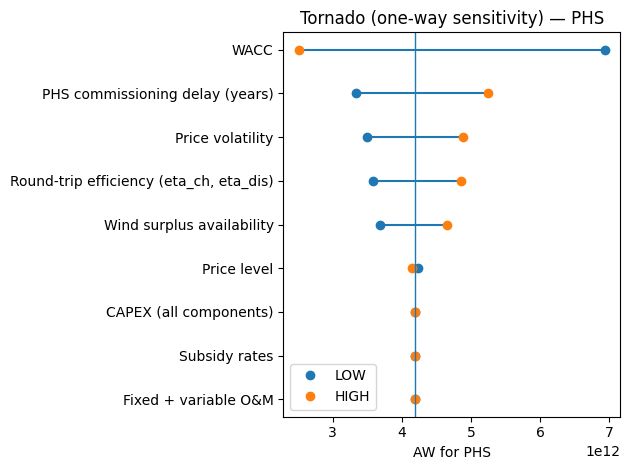

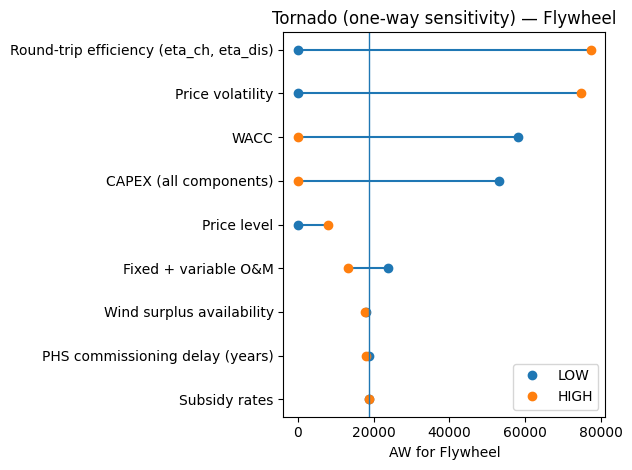

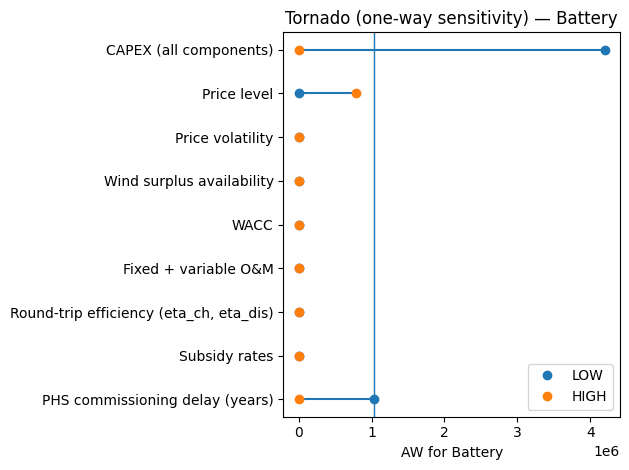

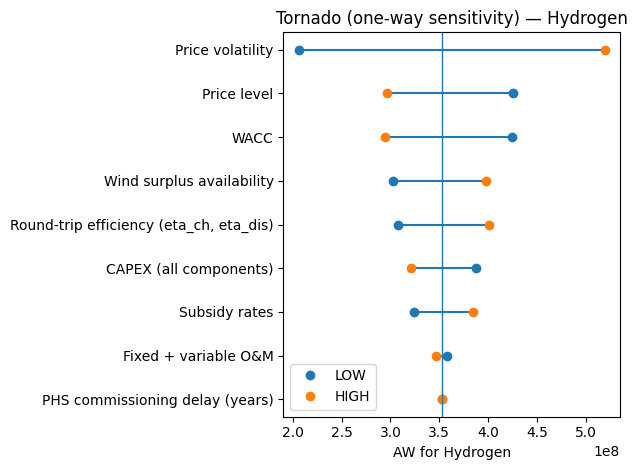

In [18]:
METRIC = "AW"

tornado_all = []
for ref_tech in TECHS_TO_RUN:
    base_val = float(summary_base.loc[summary_base["tech"]==ref_tech, METRIC].iloc[0])

    for d in OAT_DRIVERS:
        low_val  = float(oat[(oat["driver"]==d["name"]) & (oat["bound"]=="low")  & (oat["tech"]==ref_tech)][METRIC].iloc[0])
        high_val = float(oat[(oat["driver"]==d["name"]) & (oat["bound"]=="high") & (oat["tech"]==ref_tech)][METRIC].iloc[0])

        tornado_all.append({
            "tech": ref_tech,
            "driver": d["name"],
            "low": low_val,
            "high": high_val,
            "delta_low": low_val - base_val,
            "delta_high": high_val - base_val,
            "span": max(abs(low_val - base_val), abs(high_val - base_val)),
        })

tornado_all = pd.DataFrame(tornado_all)
display(tornado_all.sort_values(["tech","span"], ascending=[True, False]))

for tech in TECHS_TO_RUN:
    df_t = tornado_all[tornado_all["tech"] == tech].copy()
    df_t = df_t[df_t["driver"] != "Price drift (annual)"]

    # order drivers by impact
    df_t = df_t.sort_values("span", ascending=False)

    y = np.arange(len(df_t))
    low = df_t["low"].to_numpy()
    high = df_t["high"].to_numpy()

    # baseline value for vertical reference line
    base_val = float(summary_base.loc[summary_base["tech"] == tech, METRIC].iloc[0])

    plt.figure()
    plt.hlines(y=y, xmin=np.minimum(low, high), xmax=np.maximum(low, high))
    plt.plot(low, y, "o", label="LOW")
    plt.plot(high, y, "o", label="HIGH")
    plt.axvline(base_val, linewidth=1)

    plt.yticks(y, df_t["driver"])
    plt.xlabel(f"{METRIC} for {tech}")
    plt.title(f"Tornado (one-way sensitivity) — {tech}")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
# ============================================================
# BREAK-EVEN (THRESHOLD) ANALYSIS — auto vs baseline best tech
# - Picks incumbent = best tech from `summary` (by AW)
# - Tests all other techs (challengers) against incumbent
# - Uses bisection on CAPEX scale or WACC scale for each challenger
# ============================================================

import numpy as np
import pandas as pd

# -----------------------------
# User settings (edit as needed)
# -----------------------------
METRIC = "aw"        # solver metric key: "aw" or "npv" (must exist in solve results dict)
DRIVER = "capex"     # "capex" or "wacc"

TIME_LIMIT = 600.0
TOL_REL    = 1e-3
MAX_ITER   = 25

# Challenger-only search bounds
CAPEX_MIN  = 0.01    # 0.10 means 90% CAPEX reduction
CAPEX_MAX  = 1.50    # not used in downward search, but kept for completeness


# -----------------------------
# Internal helpers
# -----------------------------
def _get_metric(res: dict, metric: str) -> float:
    v = res.get(metric, np.nan)
    try:
        return float(v)
    except Exception:
        return np.nan

def _solve_metric(tech: str,
                  td_override: dict | None = None,
                  wacc_override: float | None = None,
                  metric: str = "aw") -> float:
    r = _call_solve_with_td_override(
        tech_name=tech,
        td_override=td_override,
        wacc_override=wacc_override,
        prices_override=_prices_base,
        surplus_override=_surplus_base,
        price_drift_override=_drift_base,
        time_limit=TIME_LIMIT,
        output_flag=0,
        prevent_simultaneous=True,
    )
    return _get_metric(r, metric)

def _capex_override_for_scale(tech: str, scale: float) -> dict:
    td = TECH[tech]
    return {
        "capex_E":    float(td["capex_E"])    * float(scale),
        "capex_Pch":  float(td["capex_Pch"])  * float(scale),
        "capex_Pdis": float(td["capex_Pdis"]) * float(scale),
    }

def _wacc_from_scale(tech: str, scale: float) -> float:
    base = float(WACC_BY_TECH.get(tech, _discount_rate_default))
    return base * float(scale)

def _find_threshold_bisect(f, lo, hi, tol_rel=1e-3, max_iter=25):
    """
    Find threshold in [lo, hi] where f crosses 0.
    We aim for the largest 'scale' that still satisfies f(scale) >= 0,
    because for CAPEX/WACC we search from baseline (1.0) downwards.
    """
    flo = f(lo)
    fhi = f(hi)

    if np.isnan(flo) or np.isnan(fhi):
        raise RuntimeError(f"NaN encountered in bracket evaluations: f(lo)={flo}, f(hi)={fhi}")

    # Require a sign change
    if flo < 0 and fhi < 0:
        raise RuntimeError(f"No crossing in bracket: f(lo)={flo}, f(hi)={fhi}")
    if flo >= 0 and fhi >= 0:
        # Entire bracket satisfies; threshold is hi (closest to baseline)
        return hi, fhi

    # Ensure we have f(lo) >= 0 and f(hi) < 0 with lo < hi
    # (lo is "better" scale, hi is "worse" scale)
    if flo < 0 and fhi >= 0:
        lo, hi = hi, lo
        flo, fhi = fhi, flo

    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        fmid = f(mid)
        if np.isnan(fmid):
            raise RuntimeError(f"NaN encountered at mid={mid}")

        if fmid >= 0:
            lo = mid  # move toward baseline, keep feasibility
            flo = fmid
        else:
            hi = mid
            fhi = fmid

        if abs(hi - lo) / max(1e-12, abs(hi)) <= tol_rel:
            break

    return lo, flo


# -----------------------------
# Determine incumbent = best tech from summary table
# -----------------------------
_summary_df = summary.copy()

# Map solver metric name -> summary column name
metric_to_summary_col = {"aw": "AW", "npv": "NPV"}
if METRIC.lower() not in metric_to_summary_col:
    raise ValueError(f"METRIC must be one of {list(metric_to_summary_col.keys())}, got '{METRIC}'")

summary_col = metric_to_summary_col[METRIC.lower()]

incumbent = _summary_df.sort_values(summary_col, ascending=False).iloc[0]["tech"]
techs_all = list(TECH.keys())
challengers = [t for t in techs_all if t != incumbent]

print(f"Incumbent (best by {summary_col}): {incumbent}")
print("Challengers:", challengers)


# -----------------------------
# Precompute incumbent baseline metric once
# -----------------------------
inc_base = _solve_metric(incumbent, td_override=None, wacc_override=None, metric=METRIC)
print(f"Baseline {METRIC.upper()} — incumbent {incumbent}: {inc_base:,.6g}")


# -----------------------------
# Threshold routine per challenger
# -----------------------------
def compute_threshold_vs_incumbent(challenger: str) -> dict:
    chal_base = _solve_metric(challenger, td_override=None, wacc_override=None, metric=METRIC)
    gap_base = chal_base - inc_base

    out = {
        "incumbent": incumbent,
        "challenger": challenger,
        "metric": METRIC,
        "driver": DRIVER,
        "baseline_incumbent": inc_base,
        "baseline_challenger": chal_base,
        "baseline_gap(chal-inc)": gap_base,
        "threshold_scale": np.nan,
        "equiv_capex_reduction_%": np.nan,
        "baseline_wacc_%": np.nan,
        "threshold_wacc_%": np.nan,
        "notes": "",
    }

    # If already outranking
    if gap_base >= 0:
        out["threshold_scale"] = 1.0
        if DRIVER.lower() == "capex":
            out["equiv_capex_reduction_%"] = 0.0
        elif DRIVER.lower() == "wacc":
            bw = float(WACC_BY_TECH.get(challenger, _discount_rate_default))
            out["baseline_wacc_%"] = 100.0 * bw
            out["threshold_wacc_%"] = 100.0 * bw
        out["notes"] = "Already outranks at baseline"
        return out

    if DRIVER.lower() == "capex":
        # f(scale) = metric_challenger(scale) - metric_incumbent(baseline)
        def f(scale):
            ov = _capex_override_for_scale(challenger, scale)
            v = _solve_metric(challenger, td_override=ov, wacc_override=None, metric=METRIC)
            return v - inc_base

        # search downward from 1.0 until f(lo) >= 0
        hi = 1.0
        if f(hi) >= 0:
            out["threshold_scale"] = 1.0
            out["equiv_capex_reduction_%"] = 0.0
            out["notes"] = "Crossing at baseline (numerical)"
            return out

        lo = hi
        found = False
        while lo > CAPEX_MIN:
            lo = max(CAPEX_MIN, lo * 0.8)
            if f(lo) >= 0:
                found = True
                break

        if not found:
            out["notes"] = f"No crossing found down to CAPEX_MIN={CAPEX_MIN:.2f}"
            return out

        thr, _ = _find_threshold_bisect(f, lo=lo, hi=hi, tol_rel=TOL_REL, max_iter=MAX_ITER)
        out["threshold_scale"] = float(thr)
        out["equiv_capex_reduction_%"] = float((1.0 - thr) * 100.0)
        return out

    else:
        raise ValueError("DRIVER must be 'capex'.")


# -----------------------------
# Run for all challengers and show results
# -----------------------------
rows = []
for ch in challengers:
    rows.append(compute_threshold_vs_incumbent(ch))

df_thresholds = pd.DataFrame(rows)

# Order by "how hard" it is to beat incumbent:
# - For CAPEX: smaller threshold_scale means larger reduction needed
# - For WACC: smaller threshold_scale means larger WACC cut needed
df_thresholds = df_thresholds.sort_values("threshold_scale", ascending=True)

display(df_thresholds)

Incumbent (best by AW): PHS
Challengers: ['Flywheel', 'Battery', 'Hydrogen']
Baseline AW — incumbent PHS: 4.19052e+12


,incumbent,challenger,metric,driver,baseline_incumbent,baseline_challenger,baseline_gap(chal-inc),threshold_scale,equiv_capex_reduction_%,baseline_wacc_%,threshold_wacc_%,notes
0,PHS,Flywheel,aw,capex,4.190523e+12,1.877515e+04,-4.190523e+12,NaN,NaN,NaN,NaN,No crossing found down to CAPEX_MIN=0.01
1,PHS,Battery,aw,capex,4.190523e+12,1.040042e+06,-4.190522e+12,NaN,NaN,NaN,NaN,No crossing found down to CAPEX_MIN=0.01
2,PHS,Hydrogen,aw,capex,4.190523e+12,3.524723e+08,-4.190171e+12,NaN,NaN,NaN,NaN,No crossing found down to CAPEX_MIN=0.01


In [20]:
# Diagnose why Battery shows 0 in OAT
battery_cases = oat[oat["tech"] == "Battery"].copy()

cols = ["case","driver","bound","status","AW","NPV","E_MWh","Pch_MW","Pdis_MW"]
display(battery_cases[cols].sort_values(["driver","bound"]))

# Quick status overview for Battery
display(battery_cases.groupby(["driver","bound"])["status"].value_counts().unstack(fill_value=0))

# Check if "zero AW" coincides with zero sizing
display(
    battery_cases.assign(is_AW_zero = battery_cases["AW"].abs() < 1e-12)
                .groupby(["driver","bound"])["is_AW_zero"].mean()
                .rename("share_AW_zero")
                .reset_index()
)


,case,driver,bound,status,AW,NPV,E_MWh,Pch_MW,Pdis_MW
2,BASELINE,BASELINE,base,2,1.040042e+06,8.736158e+06,100.0,35.12283,47.381333
50,CAPEX (all components) (HIGH),CAPEX (all components),high,2,-0.000000e+00,-0.000000e+00,0.0,0.00000,0.000000
46,CAPEX (all components) (LOW),CAPEX (all components),low,2,4.198631e+06,3.526772e+07,100.0,35.12283,47.381333
58,Fixed + variable O&M (HIGH),Fixed + variable O&M,high,9,-0.000000e+00,-0.000000e+00,0.0,0.00000,0.000000
54,Fixed + variable O&M (LOW),Fixed + variable O&M,low,9,-0.000000e+00,-0.000000e+00,0.0,0.00000,0.000000
82,PHS commissioning delay (years) (HIGH),PHS commissioning delay (years),high,9,-0.000000e+00,-0.000000e+00,0.0,0.00000,0.000000
78,PHS commissioning delay (years) (LOW),PHS commissioning delay (years),low,9,1.040042e+06,8.736158e+06,100.0,35.12283,47.381333
34,Price drift (annual) (HIGH),Price drift (annual),high,2,-0.000000e+00,-0.000000e+00,0.0,0.00000,0.000000
30,Price drift (annual) (LOW),Price drift (annual),low,2,-0.000000e+00,-0.000000e+00,0.0,0.00000,0.000000
10,Price level (HIGH),Price level,high,9,7.903329e+05,6.638649e+06,100.0,35.12283,47.381333


status                                         2  9
driver                                  bound      
BASELINE                                base   1  0
CAPEX (all components)                  high   1  0
                                        low    1  0
Fixed + variable O&M                    high   0  1
                                        low    0  1
PHS commissioning delay (years)         high   0  1
                                        low    0  1
Price drift (annual)                    high   1  0
                                        low    1  0
Price level                             high   0  1
                                        low    0  1
Price volatility                        high   0  1
                                        low    1  0
Round-trip efficiency (eta_ch, eta_dis) high   0  1
                                        low    1  0
Subsidy rates                           high   0  1
                                        low    0  1
WACC                                    high   0  1
                                        low    0  1
Wind surplus availability               high   0  1
                                        low    0  1

,driver,bound,share_AW_zero
0,BASELINE,base,0.0
1,CAPEX (all components),high,1.0
2,CAPEX (all components),low,0.0
3,Fixed + variable O&M,high,1.0
4,Fixed + variable O&M,low,1.0
5,PHS commissioning delay (years),high,1.0
6,PHS commissioning delay (years),low,0.0
7,Price drift (annual),high,1.0
8,Price drift (annual),low,1.0
9,Price level,high,0.0


In [ ]:
# ============================================================
# BREAK-EVEN (THRESHOLD) ANALYSIS — auto vs baseline best tech
# - Picks incumbent = best tech from `summary` (by AW)
# - Tests all other techs (challengers) against incumbent
# - Uses bisection on CAPEX scale or WACC scale for each challenger
# ============================================================

import numpy as np
import pandas as pd

# -----------------------------
# User settings (edit as needed)
# -----------------------------
METRIC = "aw"        # solver metric key: "aw" or "npv" (must exist in solve results dict)
DRIVER = "wacc"     # "capex" or "wacc"

TIME_LIMIT = 600.0
TOL_REL    = 1e-3
MAX_ITER   = 25

# Challenger-only search bounds
WACC_MIN   = 0.05    # 0.50 means 50% of baseline WACC
WACC_MAX   = 1.50    # not used in downward search, but kept for completeness


# -----------------------------
# Internal helpers
# -----------------------------
def _get_metric(res: dict, metric: str) -> float:
    v = res.get(metric, np.nan)
    try:
        return float(v)
    except Exception:
        return np.nan

def _solve_metric(tech: str,
                  td_override: dict | None = None,
                  wacc_override: float | None = None,
                  metric: str = "aw") -> float:
    r = _call_solve_with_td_override(
        tech_name=tech,
        td_override=td_override,
        wacc_override=wacc_override,
        prices_override=_prices_base,
        surplus_override=_surplus_base,
        price_drift_override=_drift_base,
        time_limit=TIME_LIMIT,
        output_flag=0,
        prevent_simultaneous=True,
    )
    return _get_metric(r, metric)

def _capex_override_for_scale(tech: str, scale: float) -> dict:
    td = TECH[tech]
    return {
        "capex_E":    float(td["capex_E"])    * float(scale),
        "capex_Pch":  float(td["capex_Pch"])  * float(scale),
        "capex_Pdis": float(td["capex_Pdis"]) * float(scale),
    }

def _wacc_from_scale(tech: str, scale: float) -> float:
    base = float(WACC_BY_TECH.get(tech, _discount_rate_default))
    return base * float(scale)

def _find_threshold_bisect(f, lo, hi, tol_rel=1e-3, max_iter=25):
    """
    Find threshold in [lo, hi] where f crosses 0.
    We aim for the largest 'scale' that still satisfies f(scale) >= 0,
    because for CAPEX/WACC we search from baseline (1.0) downwards.
    """
    flo = f(lo)
    fhi = f(hi)

    if np.isnan(flo) or np.isnan(fhi):
        raise RuntimeError(f"NaN encountered in bracket evaluations: f(lo)={flo}, f(hi)={fhi}")

    # Require a sign change
    if flo < 0 and fhi < 0:
        raise RuntimeError(f"No crossing in bracket: f(lo)={flo}, f(hi)={fhi}")
    if flo >= 0 and fhi >= 0:
        # Entire bracket satisfies; threshold is hi (closest to baseline)
        return hi, fhi

    # Ensure we have f(lo) >= 0 and f(hi) < 0 with lo < hi
    # (lo is "better" scale, hi is "worse" scale)
    if flo < 0 and fhi >= 0:
        lo, hi = hi, lo
        flo, fhi = fhi, flo

    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        fmid = f(mid)
        if np.isnan(fmid):
            raise RuntimeError(f"NaN encountered at mid={mid}")

        if fmid >= 0:
            lo = mid  # move toward baseline, keep feasibility
            flo = fmid
        else:
            hi = mid
            fhi = fmid

        if abs(hi - lo) / max(1e-12, abs(hi)) <= tol_rel:
            break

    return lo, flo


# -----------------------------
# Determine incumbent = best tech from summary table
# -----------------------------
_summary_df = summary.copy()

# Map solver metric name -> summary column name
metric_to_summary_col = {"aw": "AW", "npv": "NPV"}
if METRIC.lower() not in metric_to_summary_col:
    raise ValueError(f"METRIC must be one of {list(metric_to_summary_col.keys())}, got '{METRIC}'")

summary_col = metric_to_summary_col[METRIC.lower()]

incumbent = _summary_df.sort_values(summary_col, ascending=False).iloc[0]["tech"]
techs_all = list(TECH.keys())
challengers = [t for t in techs_all if t != incumbent]

print(f"Incumbent (best by {summary_col}): {incumbent}")
print("Challengers:", challengers)


# -----------------------------
# Precompute incumbent baseline metric once
# -----------------------------
inc_base = _solve_metric(incumbent, td_override=None, wacc_override=None, metric=METRIC)
print(f"Baseline {METRIC.upper()} — incumbent {incumbent}: {inc_base:,.6g}")


# -----------------------------
# Threshold routine per challenger
# -----------------------------
def compute_threshold_vs_incumbent(challenger: str) -> dict:
    chal_base = _solve_metric(challenger, td_override=None, wacc_override=None, metric=METRIC)
    gap_base = chal_base - inc_base

    out = {
        "incumbent": incumbent,
        "challenger": challenger,
        "metric": METRIC,
        "driver": DRIVER,
        "baseline_incumbent": inc_base,
        "baseline_challenger": chal_base,
        "baseline_gap(chal-inc)": gap_base,
        "threshold_scale": np.nan,
        "equiv_capex_reduction_%": np.nan,
        "baseline_wacc_%": np.nan,
        "threshold_wacc_%": np.nan,
        "notes": "",
    }

    # If already outranking
    if gap_base >= 0:
        out["threshold_scale"] = 1.0
        if DRIVER.lower() == "capex":
            out["equiv_capex_reduction_%"] = 0.0
        elif DRIVER.lower() == "wacc":
            bw = float(WACC_BY_TECH.get(challenger, _discount_rate_default))
            out["baseline_wacc_%"] = 100.0 * bw
            out["threshold_wacc_%"] = 100.0 * bw
        out["notes"] = "Already outranks at baseline"
        return out

    if DRIVER.lower() == "capex":
        # f(scale) = metric_challenger(scale) - metric_incumbent(baseline)
        def f(scale):
            ov = _capex_override_for_scale(challenger, scale)
            v = _solve_metric(challenger, td_override=ov, wacc_override=None, metric=METRIC)
            return v - inc_base

        # search downward from 1.0 until f(lo) >= 0
        hi = 1.0
        if f(hi) >= 0:
            out["threshold_scale"] = 1.0
            out["equiv_capex_reduction_%"] = 0.0
            out["notes"] = "Crossing at baseline (numerical)"
            return out

        lo = hi
        found = False
        while lo > CAPEX_MIN:
            lo = max(CAPEX_MIN, lo * 0.8)
            if f(lo) >= 0:
                found = True
                break

        if not found:
            out["notes"] = f"No crossing found down to CAPEX_MIN={CAPEX_MIN:.2f}"
            return out

        thr, _ = _find_threshold_bisect(f, lo=lo, hi=hi, tol_rel=TOL_REL, max_iter=MAX_ITER)
        out["threshold_scale"] = float(thr)
        out["equiv_capex_reduction_%"] = float((1.0 - thr) * 100.0)
        return out

    elif DRIVER.lower() == "wacc":
        # reducing challenger WACC should increase discounted performance
        def f(scale):
            w = _wacc_from_scale(challenger, scale)
            v = _solve_metric(challenger, td_override=None, wacc_override=w, metric=METRIC)
            return v - inc_base

        hi = 1.0
        if f(hi) >= 0:
            bw = float(WACC_BY_TECH.get(challenger, _discount_rate_default))
            out["threshold_scale"] = 1.0
            out["baseline_wacc_%"] = 100.0 * bw
            out["threshold_wacc_%"] = 100.0 * bw
            out["notes"] = "Crossing at baseline (numerical)"
            return out

        lo = hi
        found = False
        while lo > WACC_MIN:
            lo = max(WACC_MIN, lo * 0.85)
            if f(lo) >= 0:
                found = True
                break

        bw = float(WACC_BY_TECH.get(challenger, _discount_rate_default))
        out["baseline_wacc_%"] = 100.0 * bw

        if not found:
            out["notes"] = f"No crossing found down to WACC_MIN={WACC_MIN:.2f}"
            return out

        thr, _ = _find_threshold_bisect(f, lo=lo, hi=hi, tol_rel=TOL_REL, max_iter=MAX_ITER)
        out["threshold_scale"] = float(thr)
        out["threshold_wacc_%"] = 100.0 * (bw * thr)
        return out

    else:
        raise ValueError("DRIVER must be 'capex' or 'wacc'.")


# -----------------------------
# Run for all challengers and show results
# -----------------------------
rows = []
for ch in challengers:
    rows.append(compute_threshold_vs_incumbent(ch))

df_thresholds = pd.DataFrame(rows)

# Order by "how hard" it is to beat incumbent:
# - For CAPEX: smaller threshold_scale means larger reduction needed
# - For WACC: smaller threshold_scale means larger WACC cut needed
df_thresholds = df_thresholds.sort_values("threshold_scale", ascending=True)

display(df_thresholds)

Incumbent (best by AW): PHS
Challengers: ['Flywheel', 'Battery', 'Hydrogen']
Baseline AW — incumbent PHS: 4.19052e+12
